# Importación de librerias

In [2]:
# Procesamiento de datos
import numpy as np
import pandas as pd
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn import preprocessing as prp
transform = prp.MinMaxScaler()

# Graficadores
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Lectura del dataset

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
df = pd.read_csv('covid_limpio.csv')
# df = pd.read_csv('/content/drive/Othercomputers/Notebooks lab/Notebooks/PSY Covid/covid_limpio.csv')
df_label = None
df_label = pd.DataFrame(df.iloc[:,0:14])
df.head(5)

Life_Change_1  Life_Change_2  Life_Change_3  Life_Change_4  Life_Change_5  \
0           -2.0            0.0            0.0            0.0            0.0   
1            2.0            2.0            2.0            2.0            2.0   
2           -1.0            0.0            2.0            0.0            1.0   
3            2.0            0.0            2.0            2.0            1.0   
4            0.0           -1.0            2.0            0.0            0.0   

   Life_Change_6  Life_Change_7  Life_Change_8  Life_Change_9  Growth_1  ...  \
0            2.0            0.0            1.0            1.0       3.0  ...   
1            2.0            2.0            2.0            2.0       3.0  ...   
2           -1.0           -1.0           -1.0            1.0       1.0  ...   
3            2.0            0.0            0.0            1.0       1.0  ...   
4            2.0            2.0            1.0            1.0       1.0  ...   

   Cluster_4  Cluster_5  Country  Education  Income  Gender   Age  Covid_Self  \
0        0.0        0.0    147.0        3.0     1.0     2.0  38.0         2.0   
1        0.0        0.0    147.0        3.0     2.0     3.0  28.0         3.0   
2        0.0        0.0    147.0        2.0     1.0     1.0  42.0         0.0   
3        0.0        0.0    147.0        3.0     1.0     1.0  43.0         0.0   
4        0.0        0.0    147.0        3.0     1.0     1.0  39.0         0.0   

   Stay_Home  Form_Channel  
0        1.0           2.0  
1        2.0           3.0  
2        0.0           2.0  
3        0.0           2.0  
4        1.0          10.0  

[5 rows x 123 columns]

Para la determinación del score de resilencia, cuyo objetivo es cuantizar la medida de crecimiento pos-traumatico de las personas, se obtiene la media geómetrica de las herramientas life_change y growth, debido a que estas tienen el sustento de ser las adecuadas para capturar la autopercepcion de un individuo. 

In [5]:
df_label['score_LC'] = df_label.iloc[:,0:9].sum(axis=1) / 18
df_label['score_G'] = df_label.iloc[:,9:14].sum(axis=1) / 15

In [6]:
df_label.describe()

Life_Change_1  Life_Change_2  Life_Change_3  Life_Change_4  \
count   82776.000000   82776.000000   82776.000000   82776.000000   
mean       -0.463637      -0.462103       0.064753      -0.625036   
std         1.216550       1.052687       1.058614       0.942489   
min        -2.000000      -2.000000      -2.000000      -2.000000   
25%        -1.000000      -1.000000      -1.000000      -1.000000   
50%        -1.000000      -1.000000       0.000000       0.000000   
75%         0.000000       0.000000       1.000000       0.000000   
max         2.000000       2.000000       2.000000       2.000000   

       Life_Change_5  Life_Change_6  Life_Change_7  Life_Change_8  \
count   82776.000000   82776.000000   82776.000000   82776.000000   
mean       -0.704637       0.127187       0.034551      -0.173601   
std         1.014898       1.071872       0.763808       0.918348   
min        -2.000000      -2.000000      -2.000000      -2.000000   
25%        -2.000000      -1.000000       0.000000      -1.000000   
50%        -1.000000       0.000000       0.000000       0.000000   
75%         0.000000       1.000000       0.000000       0.000000   
max         2.000000       2.000000       2.000000       2.000000   

       Life_Change_9      Growth_1      Growth_2      Growth_3      Growth_4  \
count   82776.000000  82776.000000  82776.000000  82776.000000  82776.000000   
mean        0.517626      1.432106      1.539408      1.746605      1.516164   
std         1.040458      0.829423      0.844757      0.880652      0.994423   
min        -2.000000      0.000000      0.000000      0.000000      0.000000   
25%         0.000000      1.000000      1.000000      1.000000      1.000000   
50%         1.000000      1.000000      2.000000      2.000000      2.000000   
75%         1.000000      2.000000      2.000000      2.000000      2.000000   
max         2.000000      3.000000      3.000000      3.000000      3.000000   

           Growth_5      score_LC       score_G  
count  82776.000000  82776.000000  82776.000000  
mean       2.020151     -0.093605      0.550296  
std        0.908634      0.278693      0.226348  
min        0.000000     -1.000000      0.000000  
25%        2.000000     -0.277778      0.400000  
50%        2.000000     -0.111111      0.600000  
75%        3.000000      0.055556      0.666667  
max        3.000000      1.000000      1.000000

# Analisis espectral con KDE

Debido a la naturaleza discreta de los scores LC y G, se propone la siguiente metodologia de analísis:
1. Obtener de las scores de las herramientas "cambios conductuales" y "crecimiento".
2. Realizar un estudio espectral de densidad (KDE) mitigando la generación de valores con el fin de suavizar los efectos de la transformación a valores continuos. Esto mediante una modificación del valor de ancho de banda con el fin de conservar la distribución original.
3. Determinar el punto de equilibrio mediante un estudio de supervivencia a los resultados obtenidos en el punto anterior. La justificación de este paso proviene de la naturaleza discreta de las herramientas, ademas de que, el tamaño de los diccionarios es diferente. El score_LC lo componen 37 elementos, mientras que a score_G solo 16, es por esto que una comparación directa no es posible. 

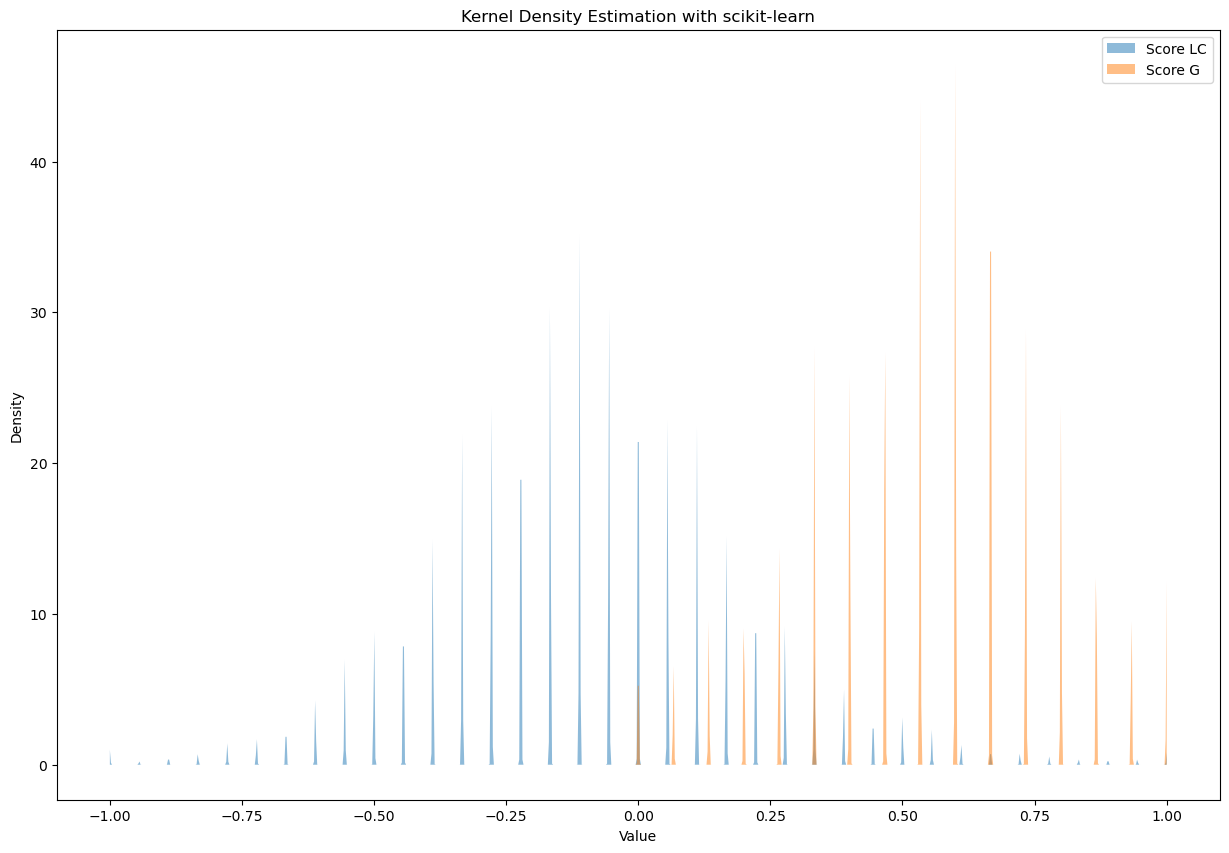

In [7]:
from sklearn.neighbors import KernelDensity

plt.figure(figsize=(15,10))
# Ajustar el modelo KernelDensity para 'score_LC'
X_LC = df_label['score_LC'].values[:, np.newaxis]
kde_LC = KernelDensity(kernel='gaussian', bandwidth=0.001).fit(X_LC)

# Ajustar el modelo KernelDensity para 'score_G'
X_G = df_label['score_G'].values[:, np.newaxis]
kde_G = KernelDensity(kernel='gaussian', bandwidth=0.001).fit(X_G)

# Crear un espacio de puntos donde evaluar las densidades
X_plot = np.linspace(min(df_label['score_LC'].min(), df_label['score_G'].min()),
                     max(df_label['score_LC'].max(), df_label['score_G'].max()), 1000)[:, np.newaxis]

# Evaluar las densidades en esos puntos
log_dens_LC = kde_LC.score_samples(X_plot)
log_dens_G = kde_G.score_samples(X_plot)

# Graficar las densidades
plt.fill_between(X_plot[:, 0], np.exp(log_dens_LC), alpha=0.5, label='Score LC')
plt.fill_between(X_plot[:, 0], np.exp(log_dens_G), alpha=0.5, label='Score G')

# Añadir título y etiquetas
plt.title('Kernel Density Estimation with scikit-learn')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Analisis de PMF (Probability Mass Function)

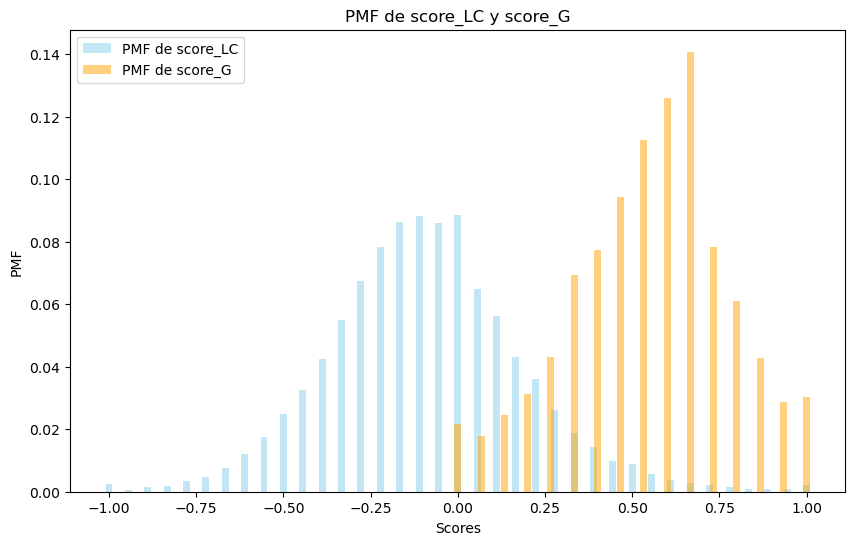

In [8]:
# Calcula las PMF de cada score
values_LC, counts_LC = np.unique(df_label['score_LC'], return_counts=True)
pmf_LC = counts_LC / counts_LC.sum()

values_G, counts_G = np.unique(df_label['score_G'], return_counts=True)
pmf_G = counts_G / counts_G.sum()

# Graficar las PMF de los scores
plt.figure(figsize=(10, 6))
plt.bar(values_LC, pmf_LC, width=0.02, alpha=0.5, color='skyblue', label='PMF de score_LC')
plt.bar(values_G, pmf_G, width=0.02, alpha=0.5, color='orange', label='PMF de score_G')

# Descripciones de la gráfica
plt.title('PMF de score_LC y score_G')
plt.xlabel('Scores')
plt.ylabel('PMF')
plt.legend();

En contraste con el analísis de KDE y PMF ambas distribuciones se asemejan, lo cual respalda la metodologia propuesta

# Heatmaps de contingencia
Para visualizar la relación entre dos variables discretas, un heatmap de contingencia puede ser útil para mostrar la frecuencia conjunta de pares de valores.

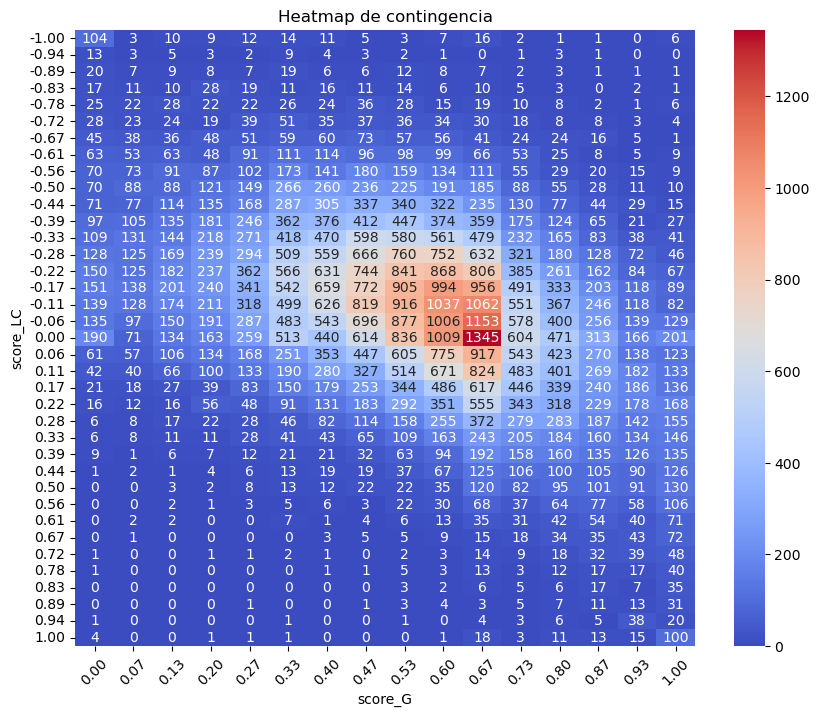

In [9]:
# Heatmap de contingencia
contingency_table = pd.crosstab(df_label['score_LC'], df_label['score_G'])

plt.figure(figsize=(10, 8))
sns.heatmap(contingency_table, cmap='coolwarm', annot=True, fmt="d")

#  ticks con dos decimales
plt.xticks([i + 0.5 for i in range(len(contingency_table.columns))],
           ['{:.2f}'.format(val) for val in contingency_table.columns], rotation=45)
plt.yticks([i + 0.5 for i in range(len(contingency_table.index))],
           ['{:.2f}'.format(val) for val in contingency_table.index], rotation=0)

# Título y etiquetas
plt.title('Heatmap de contingencia')
plt.xlabel('score_G')
plt.ylabel('score_LC');

Valores bajos (cercanos a azul): Indican que muy pocos o ningún participante obtuvieron esa combinación particular de puntuaciones en score_LC y score_G. Implica que ciertas combinaciones de cambios conductuales y crecimiento post-traumático son muy raras o no se observan en absoluto, esto podría ser relevante para la interpretación psicológica o sociológica de los datos

chaGPT:

Si el heatmap de contingencia para las variables df_label['score_LC'] (cambios conductuales) y df_label['score_G'] (crecimiento post traumático) muestra valores bajos o ceros, en particular en áreas cercanas al color amarillo, aquí hay algunas interpretaciones psicológicas y sociológicas que podrían ser aplicables:

#### Interpretación Psicológica*:

1. *Poca o Ninguna Mejora Conductual y Crecimiento Post Traumático*: Los valores bajos podrían indicar que hay individuos que no han experimentado cambios significativos en su comportamiento ni han sentido un crecimiento post traumático notable durante la pandemia. Esto podría sugerir una falta de adaptación o una resistencia al cambio, posiblemente debido a un estado de shock o negación frente a la crisis.

1. *Resistencia al Cambio*: Algunos individuos pueden tener una alta resistencia al cambio o pueden haber mantenido rutinas rígidas como mecanismo de afrontamiento, resultando en mínimos cambios conductuales.

1. *Estabilidad en Tiempos de Crisis*: Para algunos, la estabilidad en su comportamiento y la ausencia de crecimiento post traumático pueden reflejar una forma de resiliencia que se manifiesta manteniendo una constancia en sus vidas a pesar de las circunstancias externas.

#### Interpretación Sociológica:

Influencia del Contexto Socioeconómico: Los valores bajos en áreas específicas pueden reflejar cómo el contexto socioeconómico influye en la capacidad de los individuos para experimentar crecimiento o cambios positivos durante tiempos difíciles. Por ejemplo, la falta de recursos puede limitar las oportunidades para mejorar o adaptar comportamientos.

1. *Impacto del Aislamiento Social*: La pandemia ha llevado a muchas personas a experimentar aislamiento social, lo que podría estar relacionado con pocos cambios en la conducta y el crecimiento personal, ya que las interacciones sociales limitadas pueden impedir el crecimiento post traumático.

1. *Desafíos del Confinamiento*: Para aquellos con condiciones de vivienda desafiantes o un entorno de confinamiento restrictivo, es posible que haya poca oportunidad para cambios positivos en el comportamiento o el crecimiento personal.

Es importante señalar que cualquier interpretación de los datos debe hacerse con cautela, considerando la complejidad de las experiencias humanas durante la pandemia. Además, las interpretaciones deben estar respaldadas por un análisis más profundo y, si es posible, por datos cualitativos que puedan proporcionar un contexto más rico para entender las experiencias individuales detrás de los números.

Text(0, 0.5, 'score_LC')

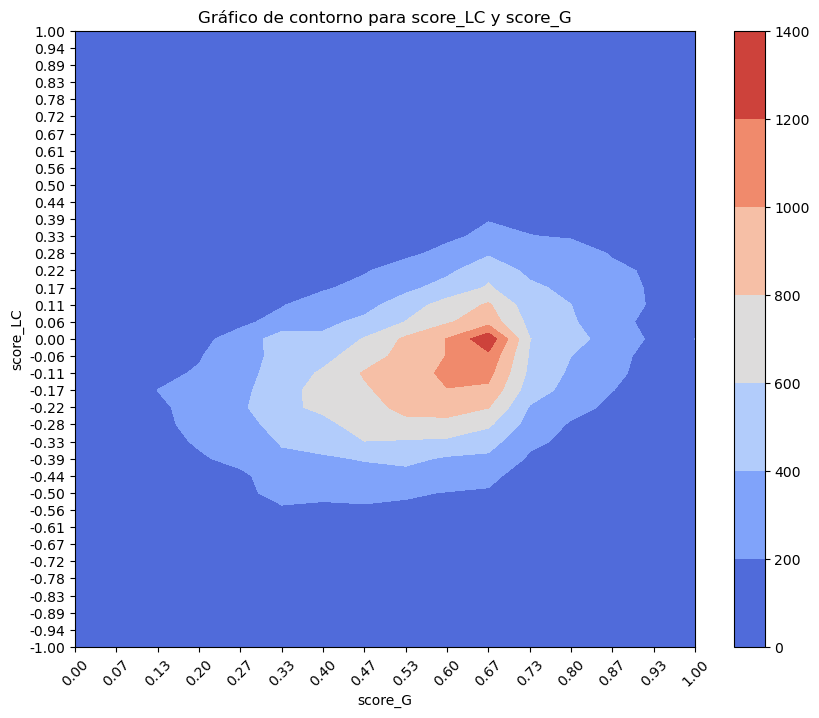

In [10]:
# Preparar los ejes X e Y con los valores únicos de score_G y score_LC
x = np.arange(len(contingency_table.columns))
y = np.arange(len(contingency_table.index))

# Preparar la malla de coordenadas para los ejes X e Y
X, Y = np.meshgrid(x, y)

# Utilizar los valores de la tabla de contingencia como alturas Z
Z = contingency_table.values

# Crear el gráfico de contorno relleno
plt.figure(figsize=(10, 8))
contour = plt.contourf(X, Y, Z, cmap='coolwarm')

# Añadir la barra de colores para interpretar los valores
plt.colorbar(contour)

# Ajustar los ticks para que muestren los valores reales de las variables
plt.xticks(x, ['{:.2f}'.format(val) for val in contingency_table.columns], rotation=45)
plt.yticks(y, ['{:.2f}'.format(val) for val in contingency_table.index])

# Título y etiquetas
plt.title('Gráfico de contorno para score_LC y score_G')
plt.xlabel('score_G')
plt.ylabel('score_LC')

Text(0, 0.5, 'score_LC')

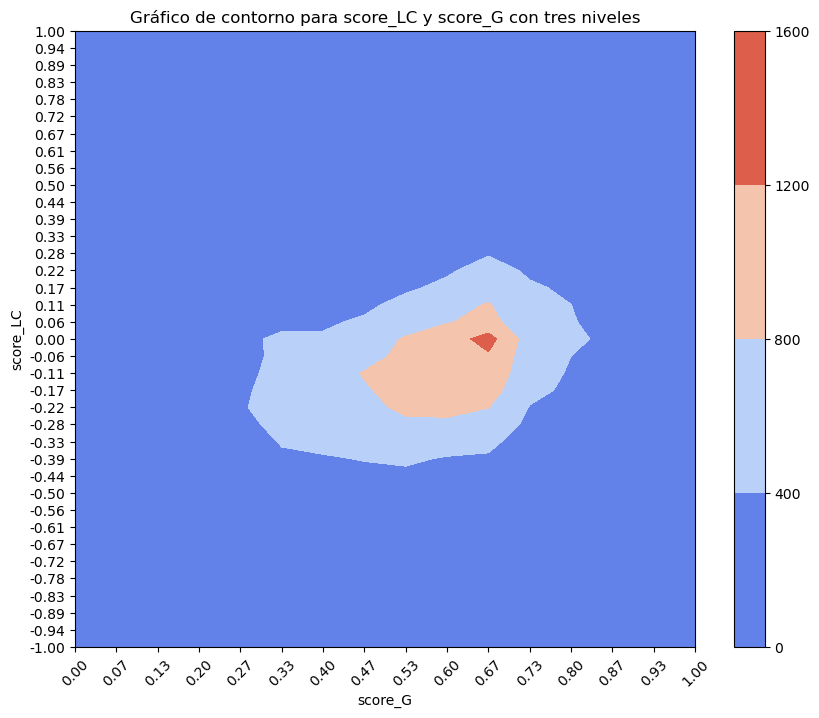

In [11]:
# Preparar los ejes X e Y con los valores únicos de score_G y score_LC
x = np.arange(len(contingency_table.columns))
y = np.arange(len(contingency_table.index))

# Preparar la malla de coordenadas para los ejes X e Y
X, Y = np.meshgrid(x, y)

# Utilizar los valores de la tabla de contingencia como alturas Z
Z = contingency_table.values

# Crear el gráfico de contorno relleno con tres niveles
plt.figure(figsize=(10, 8))
contour = plt.contourf(X, Y, Z, levels=3, cmap='coolwarm')

# Añadir la barra de colores para interpretar los valores
plt.colorbar(contour)

# Ajustar los ticks para que muestren los valores reales de las variables
plt.xticks(x, ['{:.2f}'.format(val) for val in contingency_table.columns], rotation=45)
plt.yticks(y, ['{:.2f}'.format(val) for val in contingency_table.index])

# Título y etiquetas
plt.title('Gráfico de contorno para score_LC y score_G con tres niveles')
plt.xlabel('score_G')
plt.ylabel('score_LC')

(1.0, -1.0)

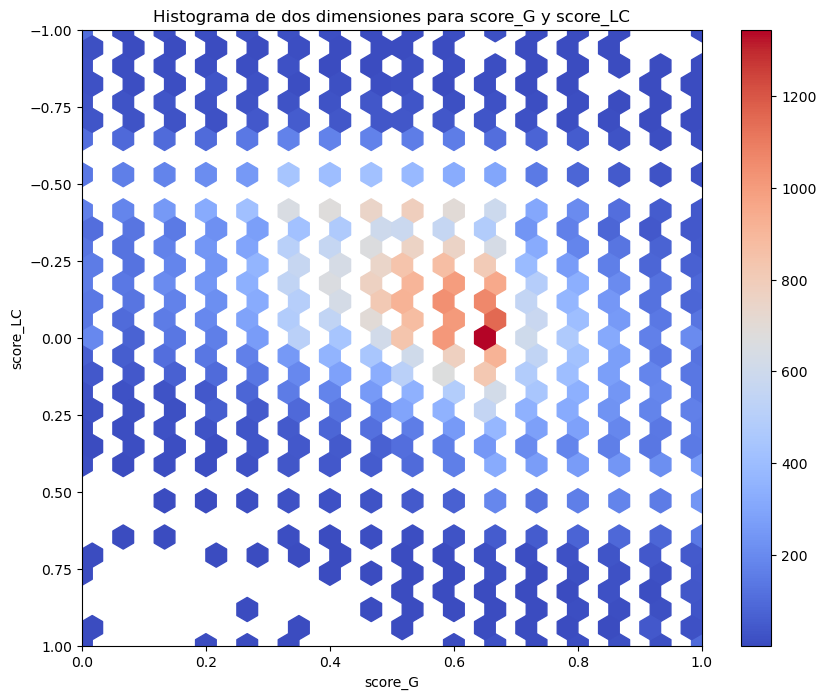

In [12]:
# Crear un histograma de dos dimensiones (también conocido como un hexbin plot o heatmap 2D)
# para las variables df_label['score_LC'] y df_label['score_G'].
plt.figure(figsize=(10, 8))
plt.hexbin(df_label['score_G'], df_label['score_LC'], gridsize=30, cmap='coolwarm', mincnt=1)
plt.colorbar()

# Título y etiquetas
plt.title('Histograma de dos dimensiones para score_G y score_LC')
plt.xlabel('score_G')
plt.ylabel('score_LC')

# Ajustar los límites de los ejes para que coincidan con los rangos de las variables
plt.xlim(0, 1)
plt.ylim(1, -1)  # Límites invertidos para el eje Y


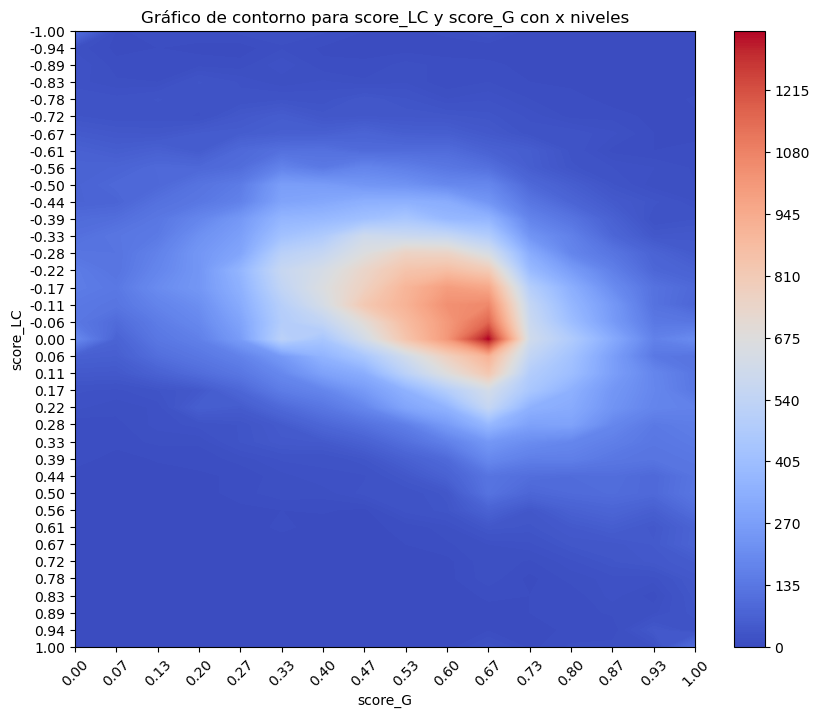

In [13]:
# Preparar los ejes X e Y con los valores únicos de score_G y score_LC
x = np.arange(len(contingency_table.columns))
y = np.arange(len(contingency_table.index))

# Invertir el orden de 'y' para que los valores en el eje Y estén al revés
y = y[::-1]

# Preparar la malla de coordenadas para los ejes X e Y
X, Y = np.meshgrid(x, y)

# Invertir los valores de la tabla de contingencia a lo largo del eje vertical para que coincidan con el eje Y invertido
Z = contingency_table.values
Z = Z[::-1, :]

# Crear el gráfico de contorno relleno
plt.figure(figsize=(10, 8))
contour = plt.contourf(X, Y, Z, levels=600, cmap='coolwarm')

# Añadir la barra de colores para interpretar los valores
plt.colorbar(contour)

# Ajustar los ticks para que muestren los valores reales de las variables
# Las etiquetas del eje Y deben ser invertidas para que el valor más bajo esté en la parte superior
plt.xticks(x, ['{:.2f}'.format(val) for val in contingency_table.columns], rotation=45)
plt.yticks(y, ['{:.2f}'.format(val) for val in contingency_table.index[::-1]])

# Título y etiquetas
plt.title('Gráfico de contorno para score_LC y score_G con x niveles')
plt.xlabel('score_G')
plt.ylabel('score_LC')

# Invertir el eje Y para que la parte superior comience en -1 y termine en 1 en la parte inferior
plt.gca().invert_yaxis()

plt.show()


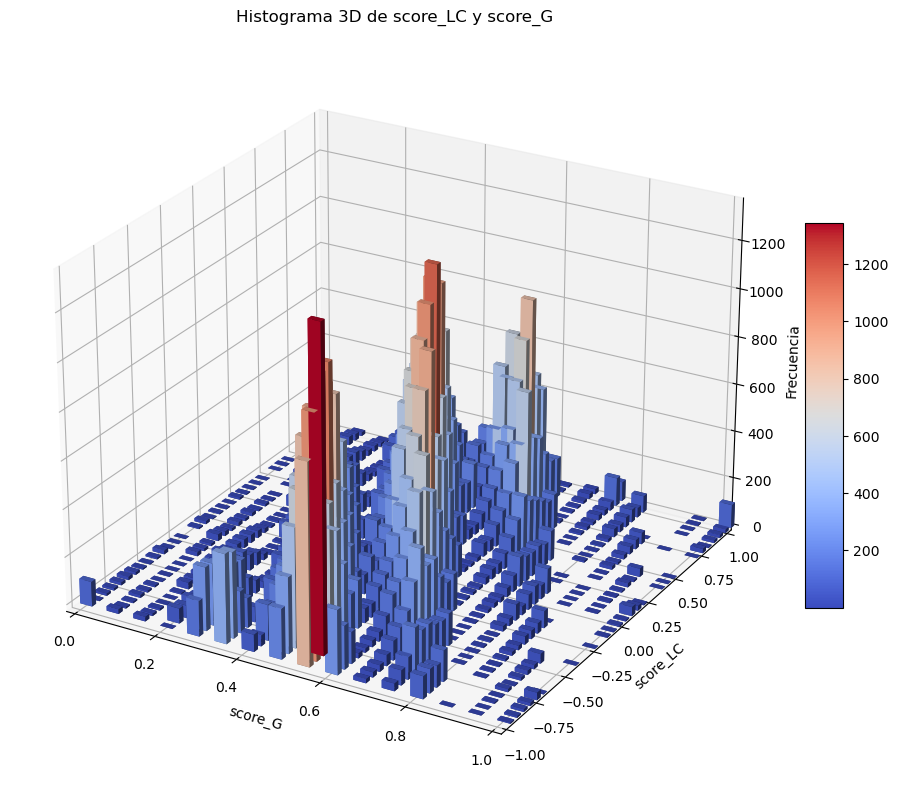

In [14]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
# Crear figura y eje para el gráfico 3D
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

# Coordenadas x, y para cada barra
xpos, ypos = np.meshgrid(contingency_table.columns, contingency_table.index, indexing="ij")

xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros_like(xpos)

# Altura de las barras
dz = contingency_table.values.flatten()

# Filtrar para eliminar las barras con altura cero
non_zero_mask = dz != 0
xpos = xpos[non_zero_mask]
ypos = ypos[non_zero_mask]
zpos = zpos[non_zero_mask]
dz = dz[non_zero_mask]

# Ancho y profundidad de las barras
dx = dy = 0.03

# Colormap
colors = plt.cm.coolwarm(dz / np.max(dz))

# Crear barras solo si la frecuencia es mayor que cero
if np.any(dz > 0):
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors)

# Configurar barra de color
norm = Normalize(dz.min(), dz.max())
mappable = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
mappable.set_array(dz)
cbar = fig.colorbar(mappable, shrink=0.5, aspect=10, pad=0.02, ax=ax)

# Título y etiquetas
ax.set_title('Histograma 3D de score_LC y score_G')
ax.set_xlabel('score_G')
ax.set_ylabel('score_LC')
ax.set_zlabel('Frecuencia')

# Ajustar límites de ejes
ax.set_xlim([min(xpos), max(xpos)])
ax.set_ylim([min(ypos), max(ypos)])
ax.set_zlim([0, max(dz)])

ax.view_init(elev=25, azim=-60)

plt.show();

# Correlación de Spearman
El coeficiente de Spearman es una mejor medida (que el coeficiente de correlación de Pearson) ya que no asume una relación lineal y que estén distribuidos normalmente y puede manejar datos ordenados pero no necesariamente continuos.

In [15]:
spearman_correlation = df_label[['score_LC', 'score_G']].corr(method='spearman')
spearman_correlation

score_LC   score_G
score_LC  1.000000  0.380553
score_G   0.380553  1.000000

Un valor de 0.347746 indica una correlación positiva moderada entre las dos variables. Significa que a medida que los valores de una variable tienden a aumentar, los valores de la otra variable también tienden a aumentar en un patrón monótono, pero no necesariamente lineal.

# Determinacion del punto de equilibrio

In [16]:
dens_diff = np.exp(log_dens_LC) - np.exp(log_dens_G)

# Encontrar los índices donde la diferencia cambia de signo
sign_change_indices = np.where(np.diff(np.sign(dens_diff)))[0]

Dado que los datos presentan una naturaleza discreta, es necesario emplear herramientas analíticas apropiadas. Esta necesidad surge de  la identificación precisa de un punto de equilibrio constituye un componente crítico para las etapas subsiguientes de nuestra propuesta.

Para determinar la variable de interés, sugerimos la siguiente metodología: se realizará la sustracción de las densidades correspondientes a cada característica dentro del conjunto de datos de cada conjunto de preguntas "cambios conductuales" y "crecimiento personal", este analisis fue realiazado previamente mediante un estudio de **KDE** (Kernel Density Estimation) y **PMF** (Probability Mass Function).

De esta manera con los resultados obtenidos previamente se procederá a ralizar una resta entre los valores de densidad de cada herramienta individual, de tal manera que, se almacenara en una lista el indice donde se presente un cambio de signo, lo cual se interpretará como un incremento en la densidad de score_G y una disminución en score_LC.

Los valores almacenados en la lista serán utilizados para el cálculo subsiguiente de un promedio geométrico o aritmético, dependiendo del caso. Este procedimiento pretende determinar el punto de equilibrio basándose en el conjunto de pares valor/densidad que reflejan un cambio significativo.

chatGPT:

Este enfoque para encontrar el punto de equilibrio promediando los valores del eje x donde ocurre un cambio de signo en la diferencia de densidades es válido y puede ser una forma efectiva de manejar la naturaleza discreta de los datos. Este método puede proporcionar un resultado que refleje mejor la transición observada visualmente entre las dos distribuciones, especialmente cuando el cambio no ocurre en un único punto bien definido, sino más bien a lo largo de un intervalo.

Calcular el promedio de los valores del eje x en los índices donde la diferencia de densidad cambia de signo ayuda a suavizar el efecto de la discretización y puede dar una estimación más representativa del "punto de equilibrio" en presencia de variabilidad o ruido en los datos. Este método es particularmente útil cuando esperas que el punto de intersección esté entre dos valores medidos, en lugar de coincidir exactamente con un punto de datos.

In [17]:
eq_point = X_plot[sign_change_indices].mean()
eq_point

0.4808356743840615

Una vez determinado el punto de equilibrio lo siguiente es la obtencion del score de resilencia a partir de score_LC y score_G

In [18]:
df_label['score_resili'] = df_label['score_LC'] + df_label['score_G']

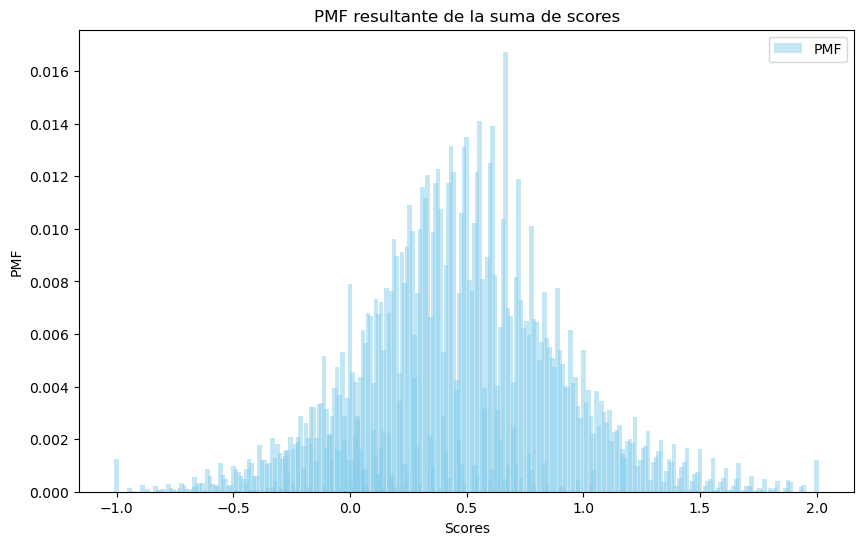

In [19]:
# Calcula las PMF de cada score
values_sum, counts_sum = np.unique(df_label['score_resili'], return_counts=True)
pmf_sum = counts_sum / counts_sum.sum()


# Graficar las PMF de los scores
plt.figure(figsize=(10, 6))
plt.bar(values_sum, pmf_sum, width=0.02, alpha=0.5, color='skyblue', label='PMF')

# Descripciones de la gráfica
plt.title('PMF resultante de la suma de scores')
plt.xlabel('Scores')
plt.ylabel('PMF')
plt.legend();

# Realizacion del etiquetado

In [20]:
df_label.iloc[:,14:].describe()

score_LC       score_G  score_resili
count  82776.000000  82776.000000  82776.000000
mean      -0.093605      0.550296      0.456690
std        0.278693      0.226348      0.423331
min       -1.000000      0.000000     -1.000000
25%       -0.277778      0.400000      0.177778
50%       -0.111111      0.600000      0.444444
75%        0.055556      0.666667      0.722222
max        1.000000      1.000000      2.000000

El etiquetado se basa en la discretización del score de resilencia. Se establecen rangos los cuales permiten dividir en tres clases las cuales tienen como objetivo establecer el tipo de crecimiento pos-traumatico:
* **Clase 0**: resilencia < 0. Aqui entran aquellas personas cuyo crecimiento fue negativo, es decir, carente de crecimiento personal y cambios conductuales negativos.

* **Clase 1**: 0 < resilencia <= 0.48. La implementacion de esta clase es necesaria pese a no ser una variable objetivo de gran importancia, recordando que el objetivo principal es la obtención de informacion de las clases negativa y positiva para asi ver las areas de oportunidad de crecimiento y de vulnerabilidad. Esta clase nace de la necesidad de ubicar a todos aquellos individuos que no experimentaron ningun tipo de crecimiento (abstinencia), o que en su defecto, la informacion proporcionada es ambigua debido al carente conocimiento del individuo sobre si mismo para poder determinar un nivel de cremienito.

* **Clase 2**: resilencia > 0.48. Crecimiento pos-tramatico positivo, donde el individuo tuvo cambios conductuales positivos y un crecimiento personal favorable.

In [21]:
df_label['Label'] = df_label['score_resili'].apply(lambda x: 0 if x < 0 else (1 if x <= eq_point else 2))
df['score_G'] = df_label['score_G']
df['score_LC'] = df_label['score_LC']
df['score_resili'] = df_label['score_resili']
df['label'] = df_label['Label']
df.iloc[:,123:].head()

score_G  score_LC  score_resili  label
0  0.933333  0.111111      1.044444      2
1  1.000000  1.000000      2.000000      2
2  0.733333  0.000000      0.733333      2
3  0.600000  0.555556      1.155556      2
4  0.800000  0.388889      1.188889      2

In [22]:
df['label'].value_counts()

label
2    38568
1    33641
0    10567
Name: count, dtype: int64

El resultado obtenido del etiquetado demuestra un dominio de la clase positiva, esto quiere decir que durante la pandemia existio una mayor cantidad de personas que experimentaron un cambio positivo. Asi mismo vemos que la clase minoritaria es la negativa. Esto se tomará en cuenta para estudios posteriores con el fin de evitar un desbalanceo de clases.

# Determinacion de la congruencia del etiquetado respecto al valor de los scores

In [23]:
# Establecer la semilla para reproducibilidad
np.random.seed(42)

# Seleccionar aleatoriamente 10 observaciones de cada clúster
selected_indices = []
for label in [0,1,2]:
    cluster_group = df[df['label'] == label]
    sampled_indices = cluster_group.sample(n=10).index.tolist()
    selected_indices.extend(sampled_indices)

# Mostrar los índices de las observaciones seleccionadas
print(selected_indices)

[32015, 27192, 48654, 62221, 65546, 37224, 2917, 33893, 20911, 24699, 82457, 15830, 58344, 13603, 66307, 16313, 35185, 31538, 38828, 79305, 13950, 74747, 24160, 35370, 71424, 20706, 59891, 2386, 50122, 61249]


In [24]:
selected_data = df_label.loc[selected_indices]

# Mostrar el nuevo DataFrame
selected_data.iloc[:30, 0:]

Life_Change_1  Life_Change_2  Life_Change_3  Life_Change_4  \
32015           -2.0           -2.0           -2.0           -1.0   
27192           -1.0           -2.0           -1.0           -1.0   
48654           -1.0            0.0            0.0           -1.0   
62221           -2.0           -2.0           -2.0           -2.0   
65546           -2.0           -1.0            0.0            0.0   
37224           -1.0           -2.0            0.0           -2.0   
2917            -2.0           -1.0            0.0           -2.0   
33893           -2.0            0.0            0.0            0.0   
20911            0.0           -2.0            0.0           -2.0   
24699           -2.0            0.0            0.0            0.0   
82457           -1.0            2.0            1.0           -2.0   
15830            0.0           -1.0            1.0            0.0   
58344            2.0           -1.0            0.0           -2.0   
13603            1.0           -1.0            0.0           -1.0   
66307           -2.0           -1.0            0.0           -1.0   
16313           -1.0            0.0            0.0            0.0   
35185           -2.0           -1.0            1.0           -1.0   
31538            0.0            0.0            0.0           -1.0   
38828           -2.0           -2.0            1.0            0.0   
79305           -1.0           -1.0           -2.0            0.0   
13950           -1.0            0.0            1.0            0.0   
74747           -2.0           -2.0            0.0           -1.0   
24160            2.0           -1.0            0.0            1.0   
35370            1.0           -2.0            1.0           -2.0   
71424            0.0            0.0            1.0            0.0   
20706            2.0           -2.0            1.0            0.0   
59891           -1.0            0.0            0.0           -1.0   
2386            -1.0            0.0            0.0           -1.0   
50122           -1.0            0.0            0.0           -1.0   
61249            0.0            1.0            1.0           -1.0   

       Life_Change_5  Life_Change_6  Life_Change_7  Life_Change_8  \
32015           -2.0            1.0           -2.0           -2.0   
27192           -2.0            0.0            0.0           -1.0   
48654           -1.0            0.0           -1.0           -1.0   
62221           -2.0            0.0            0.0            0.0   
65546           -1.0           -1.0            0.0            0.0   
37224           -1.0           -2.0           -1.0           -1.0   
2917            -2.0           -2.0            0.0            0.0   
33893            0.0           -2.0            0.0           -2.0   
20911           -2.0            0.0           -1.0           -1.0   
24699           -1.0           -1.0            0.0           -1.0   
82457           -1.0            1.0            0.0           -1.0   
15830            0.0           -1.0            0.0           -1.0   
58344           -2.0            1.0            0.0           -2.0   
13603           -1.0            0.0            0.0            0.0   
66307            0.0            0.0            0.0            0.0   
16313           -2.0            0.0            0.0           -1.0   
35185           -2.0           -1.0            0.0            0.0   
31538           -2.0            0.0           -2.0           -2.0   
38828            0.0           -1.0            0.0            0.0   
79305           -1.0           -1.0            0.0            0.0   
13950            0.0            1.0            0.0            0.0   
74747           -1.0            1.0            0.0            0.0   
24160            1.0            0.0            0.0            1.0   
35370           -2.0            1.0            0.0            0.0   
71424            0.0            0.0            0.0            0.0   
20706            0.0           -1.0            0.0            1.0   
5989

# Analisis de las distribuciones de probabilidad

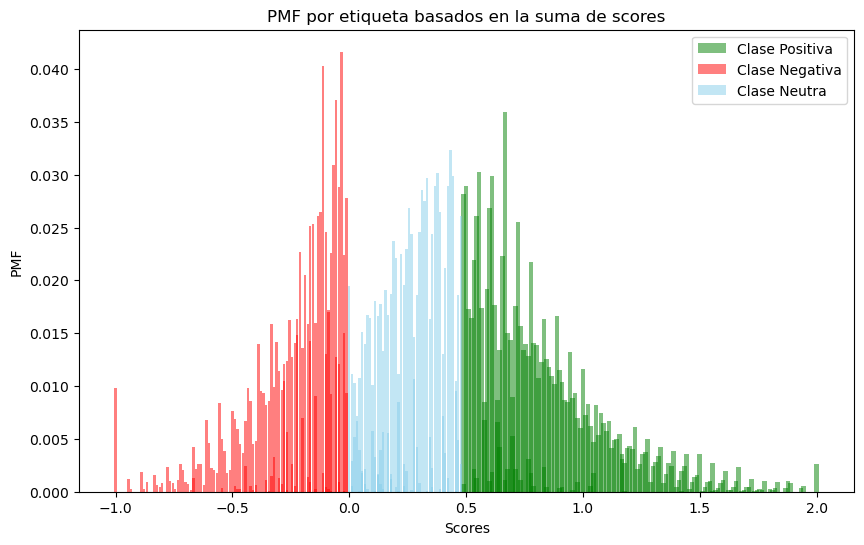

In [25]:
columns =  ['score_resili',]
# Calcula las PMF de cada score
labels_minus_one = df_label.loc[df_label['Label'] == 0, columns]
labels_plus_one = df_label.loc[df_label['Label'] == 2, columns]
labels_zero_one = df_label.loc[df_label['Label'] == 1, columns]

values_pos, counts_pos = np.unique( labels_plus_one, return_counts=True)
pmf_pos = counts_pos / counts_pos.sum()

values_neg, counts_neg = np.unique( labels_minus_one, return_counts=True)
pmf_neg = counts_neg / counts_neg.sum()

values_neu, counts_neu = np.unique( labels_zero_one, return_counts=True)
pmf_neu = counts_neu / counts_neu.sum()

# Graficar las PMF de los scores
plt.figure(figsize=(10, 6))
plt.bar(values_pos, pmf_pos, width=0.02, alpha=0.5, color='green', label='Clase Positiva')
plt.bar(values_neg, pmf_neg, width=0.01, alpha=0.5, color='red', label='Clase Negativa')
plt.bar(values_neu, pmf_neu, width=0.01, alpha=0.5, color='skyblue', label='Clase Neutra')

# Descripciones de la gráfica
plt.title('PMF por etiqueta basados en la suma de scores')
plt.xlabel('Scores')
plt.ylabel('PMF')
plt.legend();

Para el presente estudio se propone separación de clases mediante establecimiento de tres etiquetas:

1. **Clase positiva**: Toda aquella cuyo valor de score fue mayor al punto de equilibrio. La funcion del punto de equilibrio es de alguna manera resumir y generalizar la informacion proveniente de los instrumentos "cambios conductuales" y "crecimiento personal", de esta manera podemos separar de forma eficiente con un unico valor a todos aquellos individuos cuya autopercepcion ante un evento traumatico fue positiva.
2. **Clase neutra**: Pese a no ser una de clases principales u objetos de interes es necesario considerar en esta clase a todas las observaciones no asociadas a un crecimiento ni positivo ni negativo. Si no que, la informacion o conocimiento del individuo sobre si mismo no fue suficiente para dar un resultado claro dentro de las dos clases de interes, si no uno ambiguo.
3. **Clase negativa**: Aqui se encuentran todas aquellas observaciones relacionadas a un score menor que cero, en otras palabras que su score de crecimiento fue menor al de cambios conductuales. Esta calse estan asociados los individuos los cuales tuvieron un crecimiento pos-traumatico negativo.

Dado a que los individuos de interes son aquellos que presentaron un crecimiento pos-traumatico positivo como negativo, los analisis previos seran enfocados a estas dos clases.

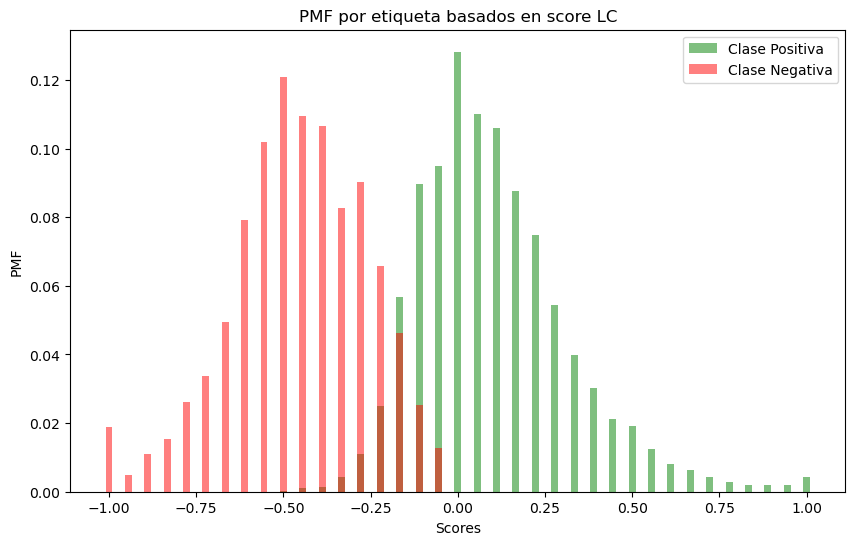

In [26]:
columns =  ['score_LC',]
# Calcula las PMF de cada score
labels_minus_one = df_label.loc[df_label['Label'] == 0, columns]
labels_plus_one = df_label.loc[df_label['Label'] == 2, columns]
labels_neu = df_label.loc[df_label['Label'] == 1, columns]

values_pos, counts_pos = np.unique( labels_plus_one, return_counts=True)
pmf_pos = counts_pos / counts_pos.sum()
values_neg, counts_neg = np.unique( labels_minus_one, return_counts=True)
pmf_neg = counts_neg / counts_neg.sum()
values_neu, counts_neu = np.unique( labels_neu, return_counts=True)
pmf_neu = counts_neu / counts_neu.sum()

# Graficar las PMF de los scores
plt.figure(figsize=(10, 6))
plt.bar(values_pos, pmf_pos, width=0.02, alpha=0.5, color='green', label='Clase Positiva')
plt.bar(values_neg, pmf_neg, width=0.02, alpha=0.5, color='red', label='Clase Negativa')
# plt.bar(values_neu, pmf_neu, width=0.02, alpha=0.5, color='skyblue', label='Clase Neutra')

# Descripciones de la gráfica
plt.title('PMF por etiqueta basados en score LC')
plt.xlabel('Scores')
plt.ylabel('PMF')
plt.legend();

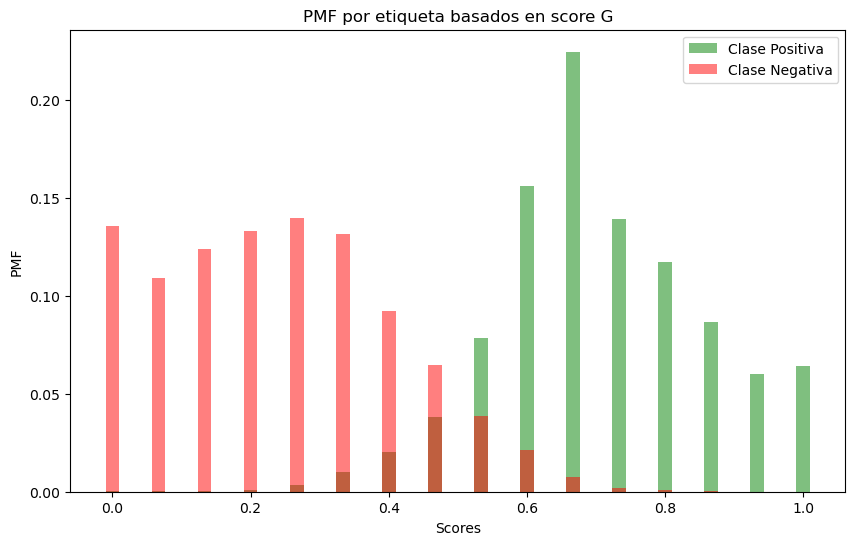

In [27]:
columns =  ['score_G',]
# Calcula las PMF de cada score
labels_minus_one = df_label.loc[df_label['Label'] == 0, columns]
labels_plus_one = df_label.loc[df_label['Label'] == 2, columns]
labels_neu = df_label.loc[df_label['Label'] == 1, columns]

values_pos, counts_pos = np.unique( labels_plus_one, return_counts=True)
pmf_pos = counts_pos / counts_pos.sum()
values_neg, counts_neg = np.unique( labels_minus_one, return_counts=True)
pmf_neg = counts_neg / counts_neg.sum()
values_neu, counts_neu = np.unique( labels_neu, return_counts=True)
pmf_neu = counts_neu / counts_neu.sum()

# Graficar las PMF de los scores
plt.figure(figsize=(10, 6))
plt.bar(values_pos, pmf_pos, width=0.02, alpha=0.5, color='green', label='Clase Positiva')
plt.bar(values_neg, pmf_neg, width=0.02, alpha=0.5, color='red', label='Clase Negativa')
# plt.bar(values_neu, pmf_neu, width=0.02, alpha=0.5, color='skyblue', label='Clase Neutra')

# Descripciones de la gráfica
plt.title('PMF por etiqueta basados en score G')
plt.xlabel('Scores')
plt.ylabel('PMF')
plt.legend()

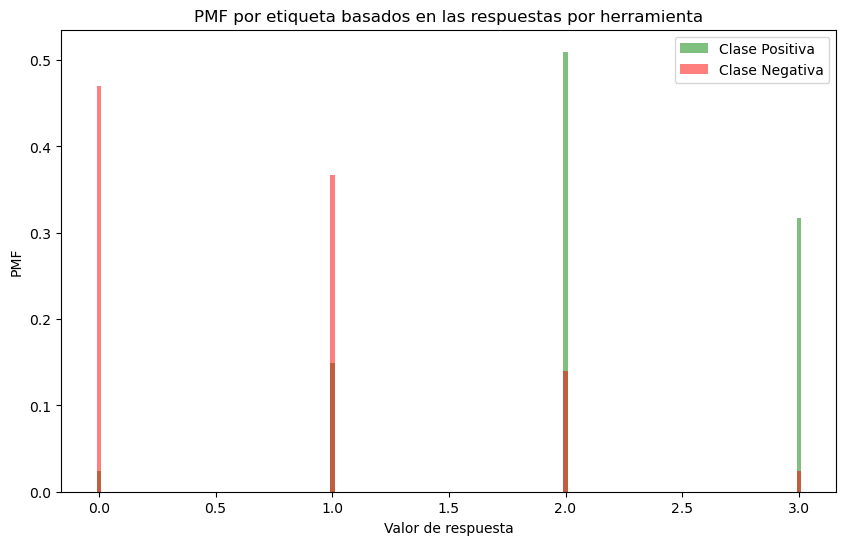

In [28]:
columns =  ['Growth_1', 'Growth_2', 'Growth_3', 'Growth_4',
       'Growth_5']
# Calcula las PMF de cada score
labels_minus_one = df_label.loc[df_label['Label'] == 0, columns]
labels_plus_one = df_label.loc[df_label['Label'] == 2, columns]

values_pos, counts_pos = np.unique( labels_plus_one, return_counts=True)
pmf_pos = counts_pos / counts_pos.sum()
values_neg, counts_neg = np.unique( labels_minus_one, return_counts=True)
pmf_neg = counts_neg / counts_neg.sum()
# values_neu, counts_neu = np.unique( df_label[df_label['Label'] == 0], return_counts=True)
# pmf_neu = counts_neu / counts_neu.sum()

# Graficar las PMF de los scores
plt.figure(figsize=(10, 6))
plt.bar(values_pos, pmf_pos, width=0.02, alpha=0.5, color='green', label='Clase Positiva')
plt.bar(values_neg, pmf_neg, width=0.02, alpha=0.5, color='red', label='Clase Negativa')
# plt.bar(values_neu, pmf_neu, width=0.02, alpha=0.5, color='skyblue', label='Clase Neutra')

# Descripciones de la gráfica
plt.title('PMF por etiqueta basados en las respuestas por herramienta')
plt.xlabel('Valor de respuesta')
plt.ylabel('PMF')
plt.legend();

# Separabilidad de las features por etiqueta

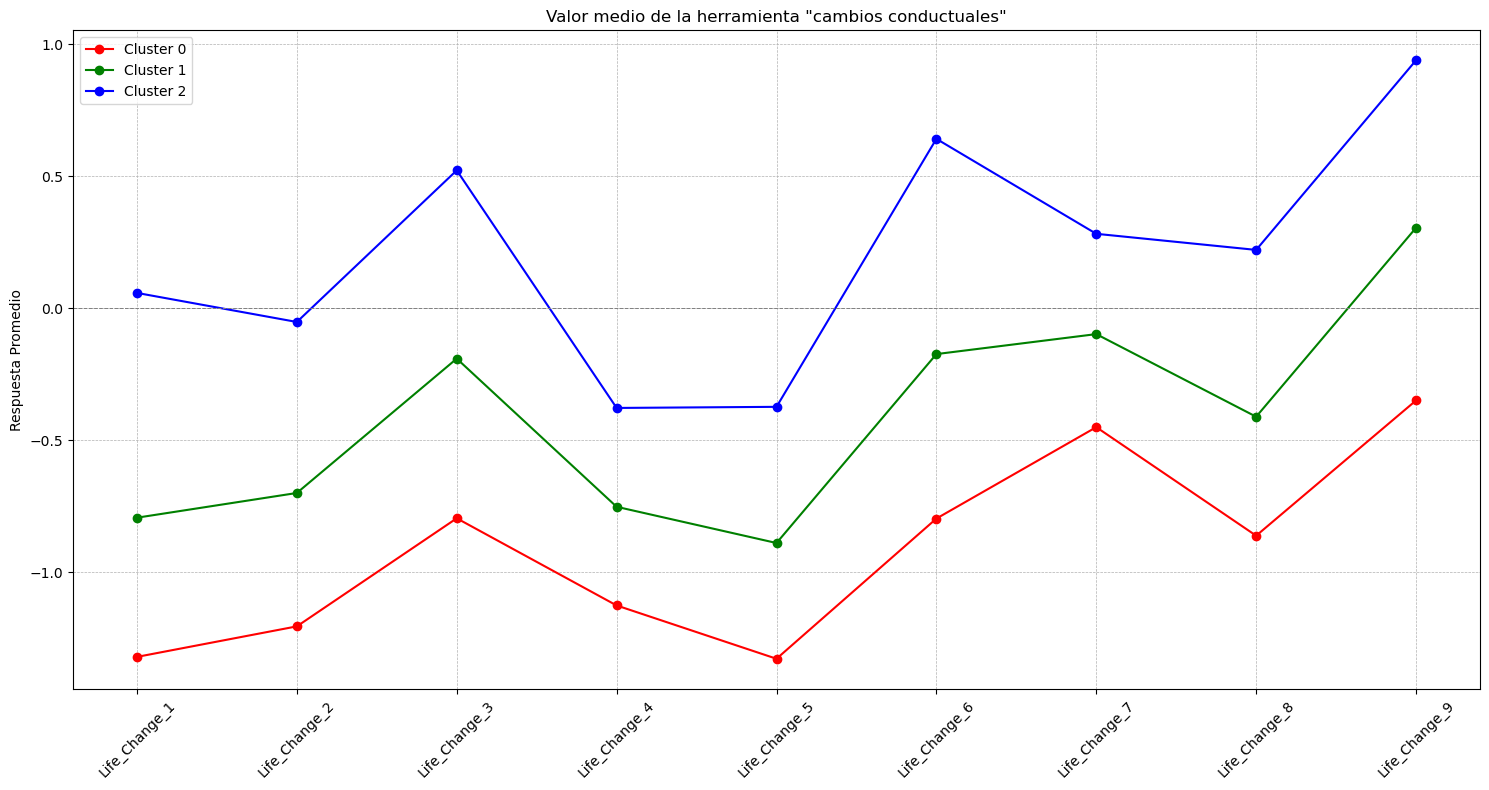

Life_Change_1  Life_Change_2  Life_Change_3  Life_Change_4  \
label                                                               
0          -1.320526      -1.204883      -0.795401      -1.125674   
1          -0.793110      -0.699444      -0.190393      -0.751821   
2           0.058520      -0.051571       0.522972      -0.377282   

       Life_Change_5  Life_Change_6  Life_Change_7  Life_Change_8  \
label                                                               
0          -1.327624      -0.796442      -0.450080      -0.861361   
1          -0.889064      -0.173211      -0.097500      -0.410541   
2          -0.373081       0.642268       0.282514       0.221505   

       Life_Change_9  
label                 
0          -0.348822  
1           0.305431  
2           0.940106

In [29]:
# Calcular la media de las respuestas de las preguntas del primer bloque para cada clúster
cluster_means = df.groupby('label')[['Life_Change_1', 'Life_Change_2', 'Life_Change_3', 'Life_Change_4',
                                         'Life_Change_5', 'Life_Change_6', 'Life_Change_7', 'Life_Change_8',
                                         'Life_Change_9']].mean()

# Visualizar las respuestas promedio para cada clúster en un gráfico
plt.figure(figsize=(15, 8))
for cluster, color in zip(cluster_means.index, ['red', 'green', 'blue']):
    plt.plot(cluster_means.columns, cluster_means.loc[cluster], color=color, marker='o', label=f'Cluster {cluster}')

plt.title('Valor medio de la herramienta "cambios conductuales"')
plt.xticks(rotation=45)
plt.ylabel('Respuesta Promedio')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)  # línea de referencia para el valor "igual"
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

cluster_means

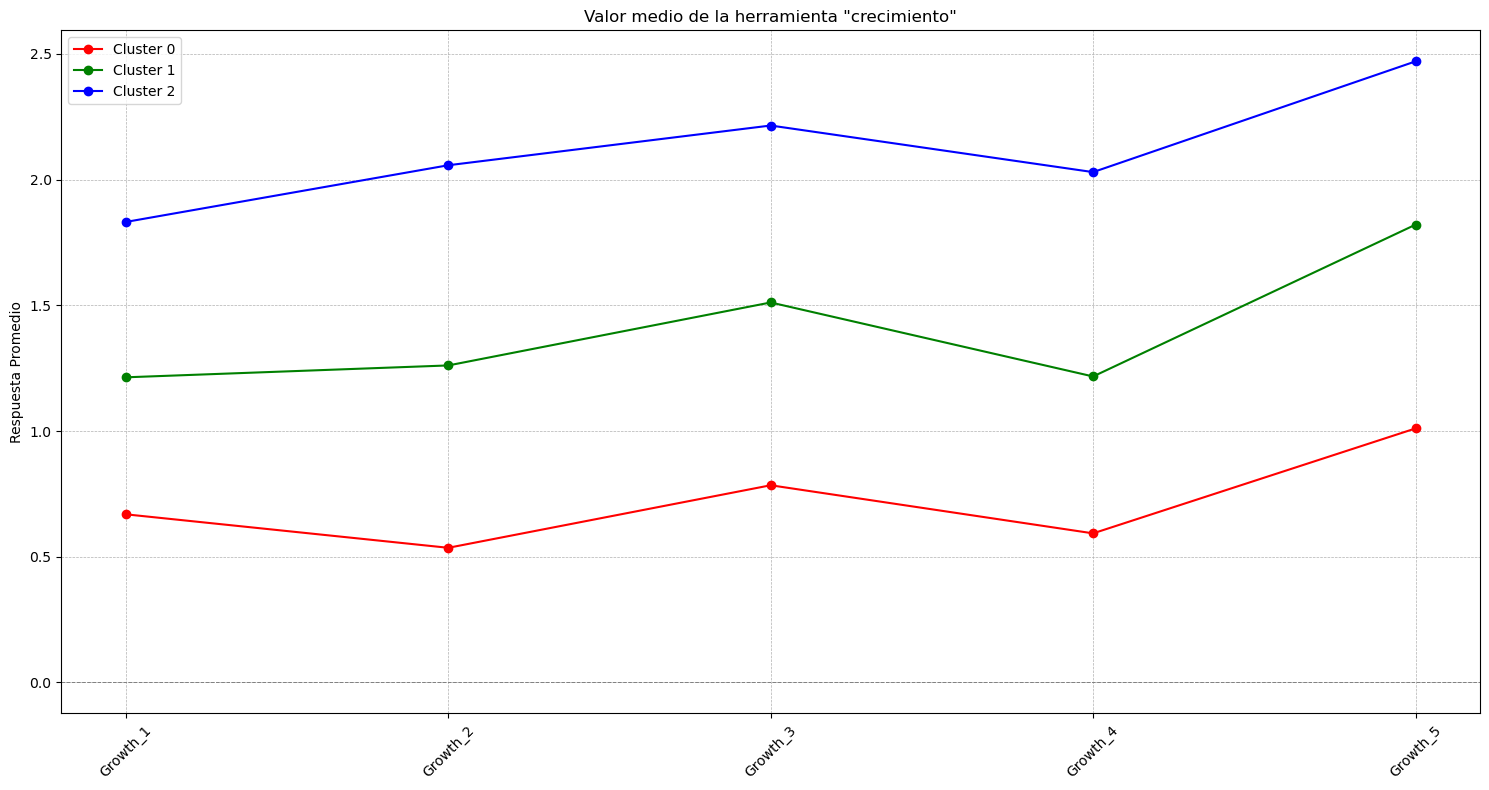

Growth_1  Growth_2  Growth_3  Growth_4  Growth_5
label                                                  
0      0.668591  0.535441  0.784234  0.592884  1.010315
1      1.213698  1.260932  1.511430  1.217057  1.820963
2      1.831804  2.057379  2.215412  2.030025  2.470571

In [30]:
# Calcular la media de las respuestas de las preguntas del primer bloque para cada clúster
cluster_means = df.groupby('label')[['Growth_1', 'Growth_2', 'Growth_3', 'Growth_4','Growth_5']].mean()

# Visualizar las respuestas promedio para cada clúster en un gráfico
plt.figure(figsize=(15, 8))
for cluster, color in zip(cluster_means.index, ['red', 'green', 'blue']):
    plt.plot(cluster_means.columns, cluster_means.loc[cluster], color=color, marker='o', label=f'Cluster {cluster}')

plt.title('Valor medio de la herramienta "crecimiento"')
plt.xticks(rotation=45)
plt.ylabel('Respuesta Promedio')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)  # línea de referencia para el valor "igual"
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

cluster_means

# Obtencion de la media aritmetica de cada herramienta

In [31]:
df_new = pd.DataFrame(df.iloc[:,14:17].mean(axis=1))
df_new = df_new.rename(columns={0:'adapt'})
df_new['prevent_exp'] = df.iloc[:,17:25].mean(axis=1)
df_new['prevent_reason'] = df.iloc[:,25:29].mean(axis=1)
df_new['follow_norms'] = df.iloc[:,29:30]
df_new['leaving_home'] = df.iloc[:,30:32].mean(axis=1)
df_new['people'] = df.iloc[:,32:33]
df_new['rooms'] = df.iloc[:,33:34]
df_new['amenit'] = df.iloc[:,34:38].mean(axis=1)
df_new['respons'] = df.iloc[:,38:41].mean(axis=1)
df_new['prevent_selfeffic'] = df.iloc[:,41:49].mean(axis=1)
df_new['prevent_outcome'] = df.iloc[:,49:57].mean(axis=1)
df_new['prevent_socialnorm'] = df.iloc[:,57:65].mean(axis=1)
df_new['adherence_factor'] = df.iloc[:,65:70].mean(axis=1)
df_new['trust'] = df.iloc[:,70:75].mean(axis=1)
df_new['info'] = df.iloc[:,75:76]
df_new['prevent_intention'] = df.iloc[:,76:84].mean(axis=1)
df_new['vulnerability_self'] = df.iloc[:,84:85]
df_new['vulnerability_others'] = df.iloc[:,85:86]
df_new['gravity_self'] = df.iloc[:,86:87]
df_new['gravity_others'] = df.iloc[:,87:88]
df_new['threat'] = df.iloc[:,88:92].mean(axis=1)
df_new['depress'] = df.iloc[:,92:94].mean(axis=1)
df_new['anxiety'] = df.iloc[:,94:96].mean(axis=1)
df_new['loneliness'] = df.iloc[:,96:97]
df_new['somatic'] = df.iloc[:,97:102].mean(axis=1)
df_new['resili'] = df.iloc[:,102:104].mean(axis=1)
df_new['perso_x'] = df.iloc[:,104:105]
df_new['perso_c'] = df.iloc[:,105:106]
df_new['perso_a'] = df.iloc[:,106:107]
df_new['perso_e'] = df.iloc[:,107:108]
df_new['perso_o'] = df.iloc[:,108:109]
df_new['perc_comp'] = df.iloc[:,109:110]
df_new['cluster'] = df.iloc[:,110:115].mean(axis=1)
df_new['country'] = df.iloc[:,115:116]
df_new['education'] = df.iloc[:,116:117]
df_new['income'] = df.iloc[:,117:118]
df_new['gender'] = df.iloc[:,118:119]
df_new['age'] = df.iloc[:,119:120]
df_new['covid_self'] = df.iloc[:,120:121]
df_new['stay_home'] = df.iloc[:,121:122]
df_new['from_channel'] = df.iloc[:,122:123]
df_new['score_G'] = df.iloc[:,123:124]
df_new['score_LC'] = df.iloc[:,124:125]
df_new['score_resili'] = df.iloc[:,125:126]
df_new['label'] = df.iloc[:,126:127]
df_raw = df
df = df_new
df.describe()

adapt   prevent_exp  prevent_reason  follow_norms  leaving_home  \
count  82776.000000  82776.000000    82776.000000  82776.000000  82776.000000   
mean       1.089027      2.015604        2.046810      2.458092      0.458563   
std        0.803064      0.540266        0.621869      0.615796      0.774128   
min       -1.333333      0.000000        0.000000      0.000000     -1.000000   
25%        0.666667      1.750000        1.500000      2.000000      0.000000   
50%        1.333333      2.000000        2.000000      3.000000      0.500000   
75%        1.666667      2.375000        2.500000      3.000000      1.000000   
max        2.666667      3.000000        3.000000      3.000000      3.000000   

             people         rooms        amenit       respons  \
count  82776.000000  82776.000000  82776.000000  82776.000000   
mean       3.211450      3.396081      0.497324      0.215356   
std        2.158749      1.412547      0.273418      0.223640   
min        0.000000      0.000000      0.000000      0.000000   
25%        2.000000      3.000000      0.250000      0.000000   
50%        3.000000      3.000000      0.500000      0.333333   
75%        4.000000      4.000000      0.750000      0.333333   
max       10.000000      6.000000      1.000000      1.000000   

       prevent_selfeffic  ...        income        gender           age  \
count       82776.000000  ...  82776.000000  82776.000000  82776.000000   
mean            2.238202  ...      0.840908      1.651360     35.295086   
std             0.575159  ...      0.557900      0.485359     13.871530   
min             0.000000  ...      0.000000      1.000000     16.000000   
25%             1.875000  ...      1.000000      1.000000     24.000000   
50%             2.250000  ...      1.000000      2.000000     32.000000   
75%             2.750000  ...      1.000000      2.000000     45.000000   
max             3.000000  ...      2.000000      3.000000     99.000000   

         covid_self     stay_home  from_channel       score_G      score_LC  \
count  82776.000000  82776.000000  82776.000000  82776.000000  82776.000000   
mean       0.589289      0.788284      6.850971      0.550296     -0.093605   
std        0.722676      1.115589      3.678219      0.226348      0.278693   
min        0.000000     -2.000000      1.000000      0.000000     -1.000000   
25%        0.000000      0.000000      3.000000      0.400000     -0.277778   
50%        0.000000      1.000000     10.000000      0.600000     -0.111111   
75%        1.000000      2.000000     10.000000      0.666667      0.055556   
max        3.000000      2.000000     10.000000      1.000000      1.000000   

       score_resili         label  
count  82776.000000  82776.000000  
mean       0.456690      1.338274  
std        0.423331      0.692218  
min       -1.000000      0.000000  
25%        0.177778      1.000000  
50%        0.444444      1.000000  
75%        0.722222      2.000000  
max        2.000000      2.000000  

[8 rows x 45 columns]

# Analisis de colinealidad

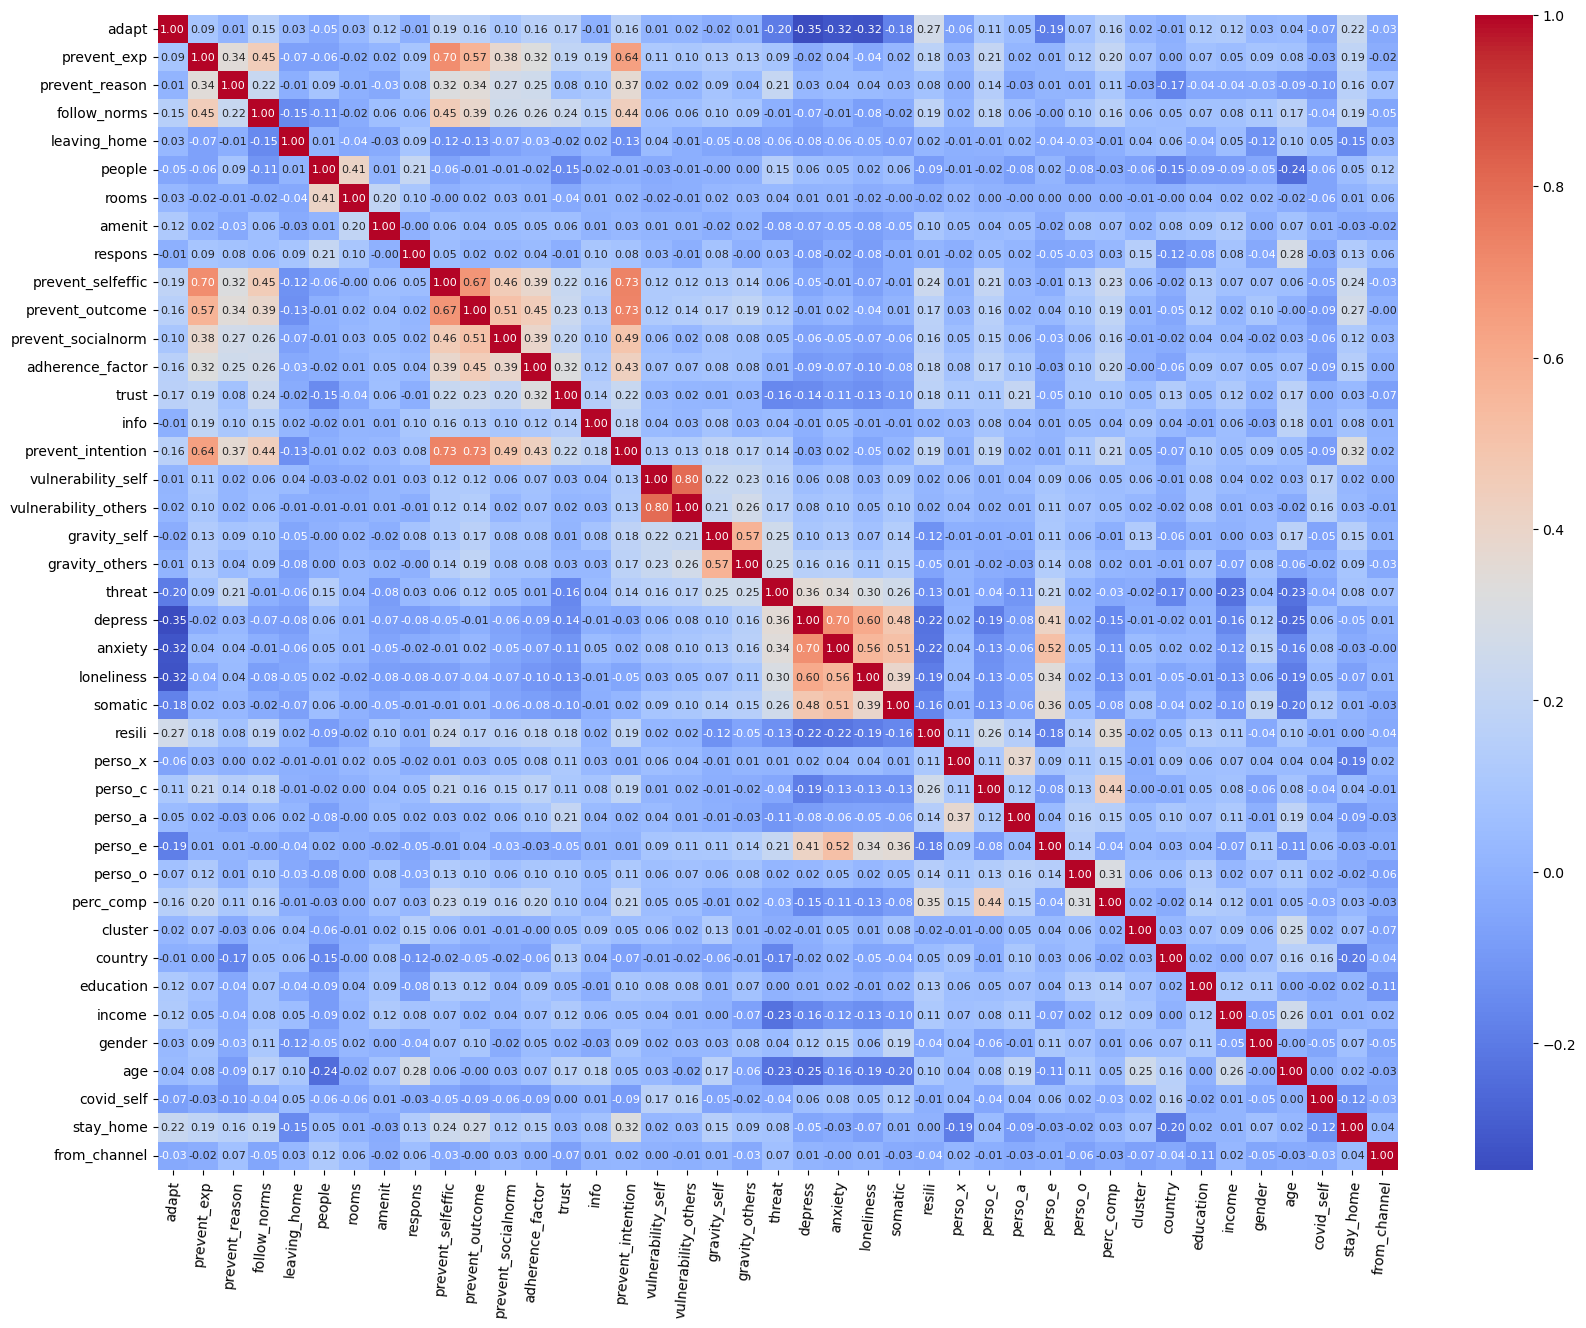

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de correlación
corr_matrix = df.drop(['score_G','score_LC','score_resili','label'], axis=1).corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", annot_kws={'size':8})
plt.xticks(rotation=85)
plt.show()

In [33]:
strong_pairs = corr_matrix.abs().stack().reset_index()
strong_pairs.columns = ['Variable 1', 'Variable 2', 'Correlación']

# Filtrar aquellos pares con una correlación >= 0.7 y que no sean la misma variable
strong_pairs = strong_pairs[(strong_pairs['Correlación'] >= 0.7) & (strong_pairs['Variable 1'] != strong_pairs['Variable 2'])]

# Eliminar duplicados, ya que la matriz es simétrica
strong_pairs = strong_pairs.drop_duplicates(subset=['Correlación'])

print(strong_pairs)

             Variable 1            Variable 2  Correlación
50          prevent_exp     prevent_selfeffic     0.703060
384   prevent_selfeffic     prevent_intention     0.732153
425     prevent_outcome     prevent_intention     0.729466
673  vulnerability_self  vulnerability_others     0.802061


Es necesaria la determinacion de aquellas features las cuales tengan mayor correlacion. En este caso vemos que las columnas "prevent_selffic" y "prevent_intention" se encuentran repetidas, por ende se tomara la decision de extraerlas del conjunto de datos original.

Las herramientas de "vulnerability" presentan un alto nivel de correlacion. El criterio para determinar cual feature debe ser extraida se basa en la busqueda de aquella que presente una mayor correlacion con las extraidas previamente. Sin embargo, el criterio establecido no se cumple para este caso debido a que ambas presentan el mismo nivel de correlacion.

Para decididr cual de las dos herramientas debe ser extraida es importante conocer el contexto y objetivo de cada una de ellas:
* vulnerability_self: Describe a probabilidad de que el individuo se contagie en el futuro de coronavirus.
* vulnerability_others: Describe la probabilidad de que, las personas cercanas al entorno del individuo se contagien de coronavirus.

Debio a que la obtencion de la variable objetivo se baso en la autopercepcion del individuo (herramientas "life_change" y "growth"), suena coherente conservar aquellas que hablen sobre la autoevaluacion y percepcion del ambiente y las posibilidades propias de cada individuo.

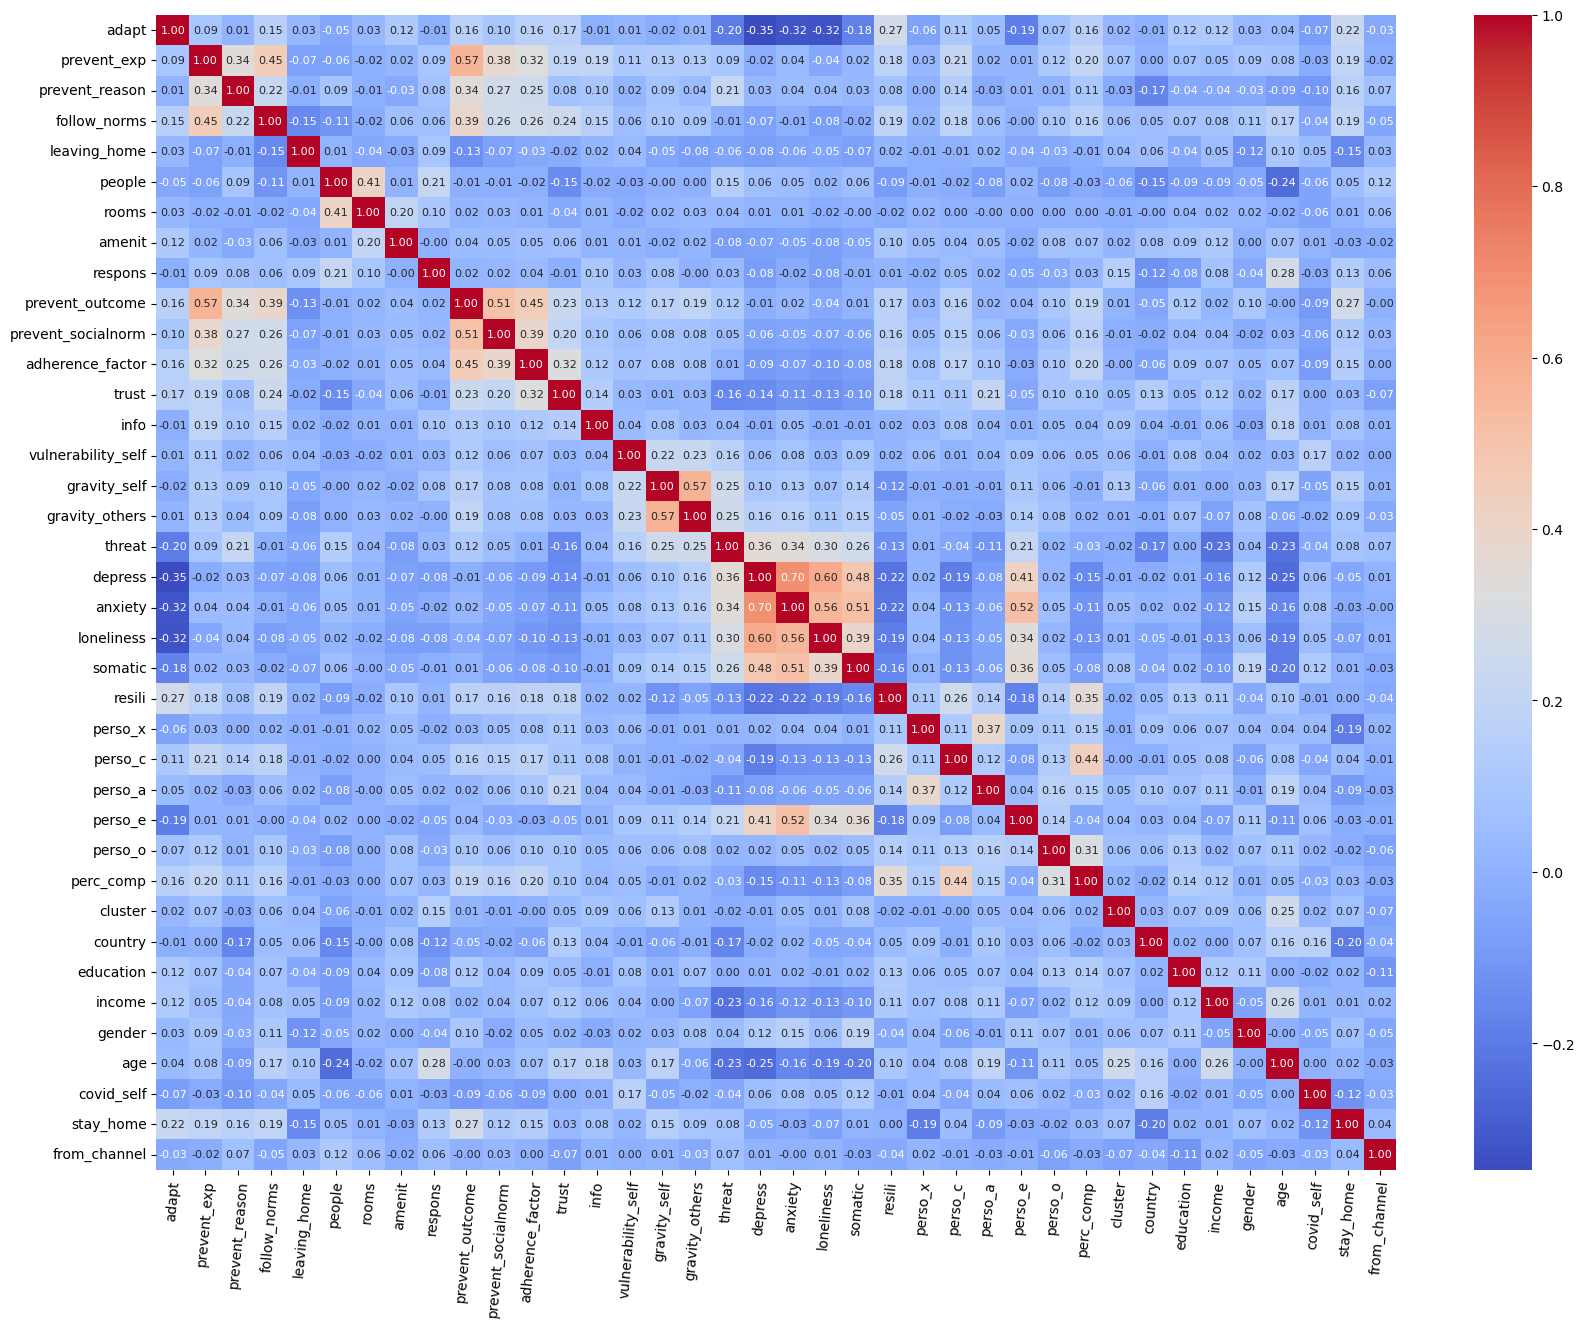

In [34]:
df.drop(['prevent_selfeffic','prevent_intention','vulnerability_others'], axis=1, inplace=True)
# Calcular la matriz de correlación
corr_matrix =  df.drop(['score_G','score_LC','score_resili','label'], axis=1).corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", annot_kws={'size':8})
plt.xticks(rotation=85)
plt.show()

In [35]:
strong_pairs = corr_matrix.abs().stack().reset_index()
strong_pairs.columns = ['Variable 1', 'Variable 2', 'Correlación']

# Filtrar aquellos pares con una correlación >= 0.7 y que no sean la misma variable
strong_pairs = strong_pairs[(strong_pairs['Correlación'] >= 0.7) & (strong_pairs['Variable 1'] != strong_pairs['Variable 2'])]

# Eliminar duplicados, ya que la matriz es simétrica
strong_pairs = strong_pairs.drop_duplicates(subset=['Correlación'])

print(strong_pairs)

Empty DataFrame
Columns: [Variable 1, Variable 2, Correlación]
Index: []


Con esto confirmamos que ya no hay valores de correlacion superiores a 0.7

# Contraste entre las clases de interes con la neutra

## Datasplit

**Clase neutra y negativa (1 y 0 respectivamente)**

In [36]:
# Seleccionar aleatoriamente 10 observaciones de cada clúster
selected_indices = []
for label in [0,1]:
    cluster_group = df[df['label'] == label]
    sampled_indices = cluster_group.sample(n=10000).index.tolist()
    selected_indices.extend(sampled_indices)

selected_data_1 = df.loc[selected_indices]

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(selected_data_1.drop(['label','score_resili','score_G','score_LC'],axis=1),selected_data_1['label'],test_size=0.1,random_state=42)
x_train_1.shape,x_test_1.shape

transform.fit(x_train_1)
x_train_1_norm = pd.DataFrame(transform.transform(x_train_1))
x_test_1_norm = pd.DataFrame(transform.transform(x_test_1))
x_train_1_norm.columns, x_test_1_norm.columns = x_train_1.columns, x_test_1.columns
x_train_1_norm.shape, x_test_1_norm.shape

((18000, 38), (2000, 38))

**Clase neutra y positiva (0 y 1 respectivamente)**

In [37]:
# Seleccionar aleatoriamente 10 observaciones de cada clúster
selected_indices = []
for label in [1,2]:
    cluster_group = df[df['label'] == label]
    sampled_indices = cluster_group.sample(n=10000).index.tolist()
    selected_indices.extend(sampled_indices)

selected_data_2 = df.loc[selected_indices]

selected_data_2 = selected_data_2.replace({1:0,2:1})
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(selected_data_2.drop(['label', 'score_resili','score_G','score_LC'],axis=1),selected_data_2['label'],test_size=0.1,random_state=42)
x_train_2.shape,x_test_2.shape

transform.fit(x_train_2)
x_train_2_norm = pd.DataFrame(transform.transform(x_train_2))
x_test_2_norm = pd.DataFrame(transform.transform(x_test_2))
x_train_2_norm.columns, x_test_2_norm.columns = x_train_1.columns, x_test_1.columns
x_train_2_norm.shape, x_test_2_norm.shape

((18000, 38), (2000, 38))

## Seleccion de caracteristicas con arboles de decision

### Primer caso, clase negativa con clase ambigua

In [38]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

tree_1 = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_1.fit(x_train_1_norm, y_train_1)

dot = export_graphviz(
    tree_1,
    out_file=None,
    feature_names=x_test_1_norm.columns,
    class_names=['0','1'],
    filled=True,
    rounded=True,
    special_characters=True
)

import graphviz
graph = graphviz.Source(dot)
graph

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

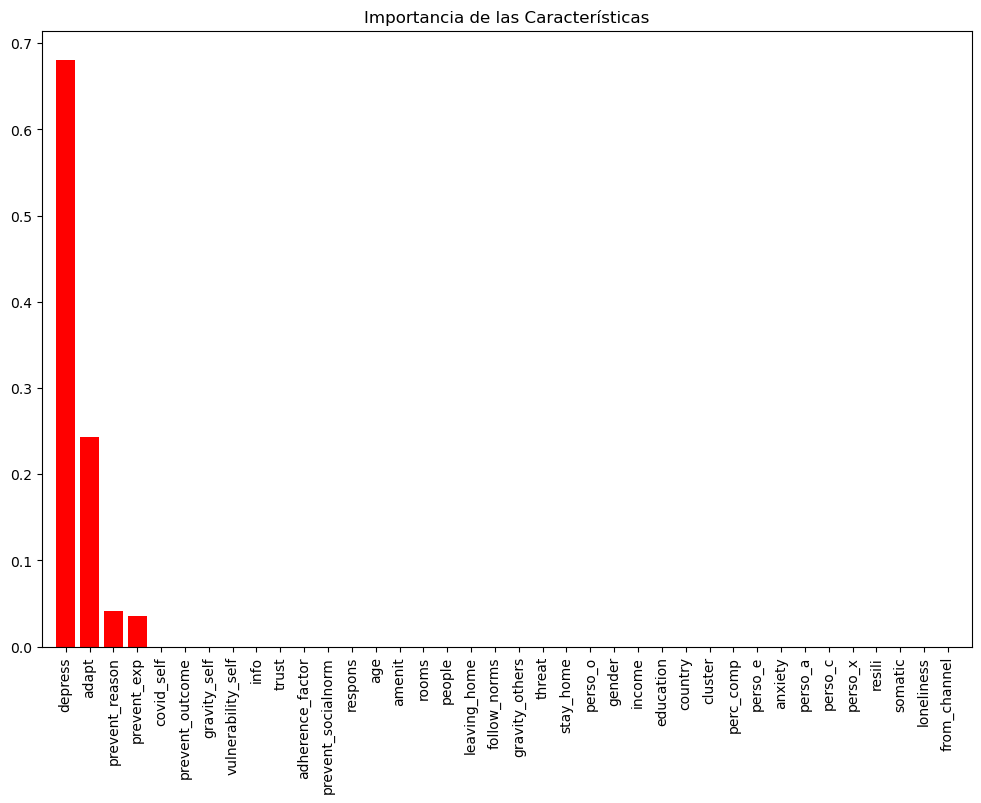

In [39]:
feature_importances = tree_1.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Importancia de las Características")
plt.bar(range(x_train_1_norm.shape[1]), feature_importances[indices],
        color="r", align="center")
plt.xticks(range(x_train_1_norm.shape[1]), x_train_1_norm.columns[indices], rotation=90)
plt.xlim([-1, x_train_1_norm.shape[1]])
plt.show()

### Segundo caso, clase positiva con clase ambigua

In [40]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

tree_2 = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_2.fit(x_train_2_norm, y_train_2)

dot = export_graphviz(
    tree_2,
    out_file=None,
    feature_names=x_test_2_norm.columns,
    class_names=['1','2'],
    filled=True,
    rounded=True,
    special_characters=True
)

import graphviz
graph = graphviz.Source(dot)
graph

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

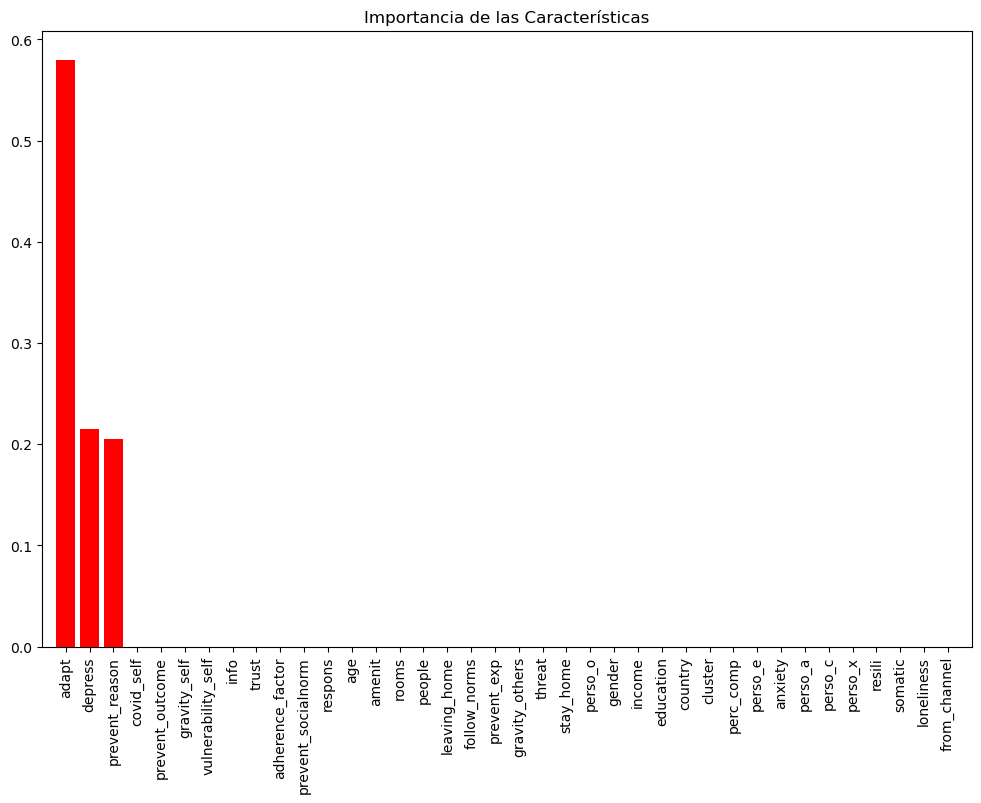

In [41]:
feature_importances = tree_2.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Importancia de las Características")
plt.bar(range(x_train_2_norm.shape[1]), feature_importances[indices],
        color="r", align="center")
plt.xticks(range(x_train_2_norm.shape[1]), x_train_2_norm.columns[indices], rotation=90)
plt.xlim([-1, x_train_2_norm.shape[1]])
plt.show()

# Contraste entre la clase negativa y la positiva

## Data split

In [42]:
# Seleccionar aleatoriamente 10 observaciones de cada clúster
selected_indices = []
for label in [0,2]:
    cluster_group = df[df['label'] == label]
    sampled_indices = cluster_group.sample(n=10000).index.tolist()
    selected_indices.extend(sampled_indices)

selected_data = df.loc[selected_indices]
# Mostrar el nuevo DataFrame
selected_data = selected_data.replace({2:1})
x_train, x_test, y_train, y_test = train_test_split(selected_data.drop(['label','score_resili','score_G','score_LC'],axis=1),selected_data['label'],test_size=0.1,random_state=42)
x_train.shape,x_test.shape

transform.fit(x_train)
x_train_norm = pd.DataFrame(transform.transform(x_train))
x_test_norm = pd.DataFrame(transform.transform(x_test))
x_train_norm.columns, x_test_norm.columns = x_train.columns, x_test.columns

## Prueba de hipotesis y significancia

In [43]:
y_train.reset_index(drop=True, inplace=True)

In [44]:
import statsmodels.api as sm

sm_model = sm.Logit(y_train,sm.add_constant(x_train_norm),)
result=sm_model.fit()
stats=result.summary()
print(stats)

Optimization terminated successfully.
         Current function value: 0.458103
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                18000
Model:                          Logit   Df Residuals:                    17961
Method:                           MLE   Df Model:                           38
Date:                Tue, 27 Feb 2024   Pseudo R-squ.:                  0.3391
Time:                        13:06:36   Log-Likelihood:                -8245.9
converged:                       True   LL-Null:                       -12477.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -4.7435      0.177    -26.738      0.000      -5.091      -4.396
adapt

El valor p indica el nivel se significancia de las features, aquellas que tienen un valor p > 0.005 se considera que no son tan relevantes para describir el fenomeno que se desea modelar, se modificará el dataset original para tomar solo quellas features que obtuvieron un valor p < 0.005.

In [45]:
train = x_train_norm[['adapt','prevent_exp','prevent_reason','follow_norms','people','adherence_factor',
'trust','gravity_others','threat','depress','loneliness','somatic','perso_x','perso_c',
'perso_e','perso_o','perc_comp','country','education','income','age','stay_home','from_channel']
]

In [46]:
sm_model = sm.Logit(y_train,sm.add_constant(train),)
result = sm_model.fit()
stats = result.summary()
print(stats)

Optimization terminated successfully.
         Current function value: 0.459507
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                18000
Model:                          Logit   Df Residuals:                    17976
Method:                           MLE   Df Model:                           23
Date:                Tue, 27 Feb 2024   Pseudo R-squ.:                  0.3371
Time:                        13:06:36   Log-Likelihood:                -8271.1
converged:                       True   LL-Null:                       -12477.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -4.8538      0.166    -29.278      0.000      -5.179      -4.529
adapt      

De esta manera se reduce la cantidad de 38 a 23 features necesarias para el entrenamiento, sin embargo, ¿como sabemos que tan bueno es este resultado?

El modelo de regresión logistica de la libreria statsmodels implementa una metrica llamada pseudo coeficiente de determinación (Pseudo R-squ), el cual varia de los rangos 0 a 1, indicando el porcentaje de la varianza que explica el modelo. Sin embargo la información dada por esta métrica es muy poca, es por esto que, para una evaluacion mas completa del modelo se usarán las siguientes scores. 

**Accuracy**
La accuracy (exactitud) mide la proporción de predicciones correctas entre el total de casos examinados.\

$Accuracy = \frac{Número de predicciones correctas}{Total de predicciones}$

**AUC Score**
El AUC score (Área Bajo la Curva ROC) es una métrica que se utiliza para evaluar modelos de clasificación binaria. La curva ROC (Receiver Operating Characteristic) es un gráfico que muestra el rendimiento del modelo de clasificación a todos los niveles de umbral de clasificación. Esta curva traza la tasa de verdaderos positivos (TPR, True Positive Rate) frente a la tasa de falsos positivos (FPR, False Positive Rate) a varios umbrales de decisión. **El AUC score representa el área bajo la curva ROC y varía entre 0 y 1. Un AUC de 1 indica un modelo perfecto, mientras que un AUC de 0.5 sugiere un rendimiento no mejor que el azar**. Un AUC menor que 0.5 indica que podrías hacerlo mejor invirtiendo las predicciones del modelo. Esta métrica es particularmente útil porque es invariante a la escala y mide la calidad de las predicciones del modelo sin importar qué umbral se elija.

**F1 Score**
El F1 score es una métrica que combina la precisión (la proporción de verdaderos positivos entre todas las predicciones positivas) y el recall (la proporción de verdaderos positivos entre todas las instancias positivas reales) en un solo número. Se calcula como el promedio armónico de precisión y recall:\

$F1 Score = 2*\frac{Precisión * Recall}{Precisión + Recall}$

In [47]:
test = x_test_norm[['adapt','prevent_exp','prevent_reason','follow_norms','people','adherence_factor',
'trust','gravity_others','threat','depress','loneliness','somatic','perso_x','perso_c',
'perso_e','perso_o','perc_comp','country','education','income','age','stay_home','from_channel']
]

## Evaluacion del modelo

In [48]:
y_test.reset_index(drop=True,inplace=True)

In [49]:
y_pred_probs = result.predict(exog=sm.add_constant(test))
y_pred = (y_pred_probs >= 0.5).astype(int)

Accuracy: 0.778
Confusion Matrix:
[[783 240]
 [204 773]]
AUC Score: 0.860399151150959
F1 Score: 0.7768844221105526


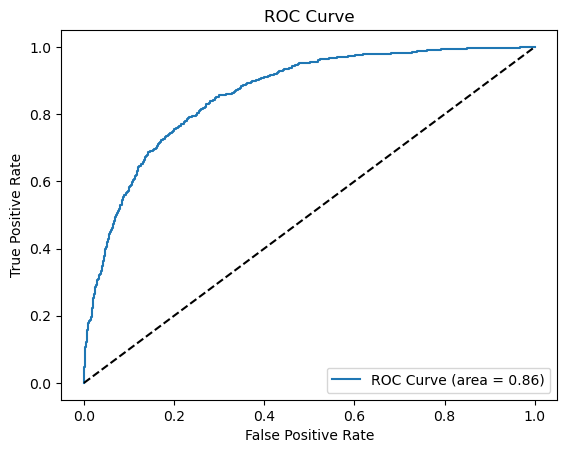

In [50]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score, roc_curve

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

# Calcular la puntuación AUC
# Para AUC necesitamos las probabilidades, no las clases predichas
auc_score = roc_auc_score(y_test, y_pred_probs)
print(f"AUC Score: {auc_score}")

# Calcular la puntuación F1
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

# Generar la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Feature selection con arboles de decision

In [51]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

tree_1 = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_1.fit(train, y_train_1)

dot = export_graphviz(
    tree_1,
    out_file=None,
    feature_names=train.columns,
    class_names=['0','1'],
    filled=True,
    rounded=True,
    special_characters=True
)

import graphviz
graph = graphviz.Source(dot)
graph

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

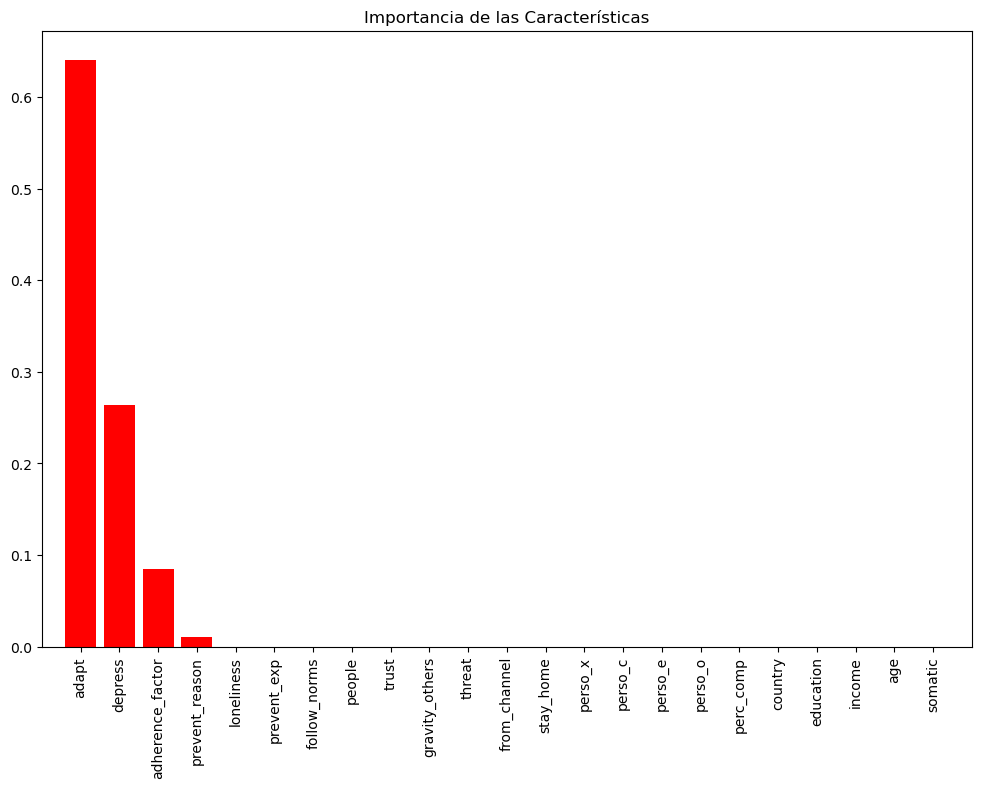

In [52]:
feature_importances = tree_1.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Importancia de las Características")
plt.bar(range(train.shape[1]), feature_importances[indices],
        color="r", align="center")
plt.xticks(range(train.shape[1]), train.columns[indices], rotation=90)
plt.xlim([-1, train.shape[1]])
plt.show()

## Analisis de separabilidad

**Herramienta adapt**

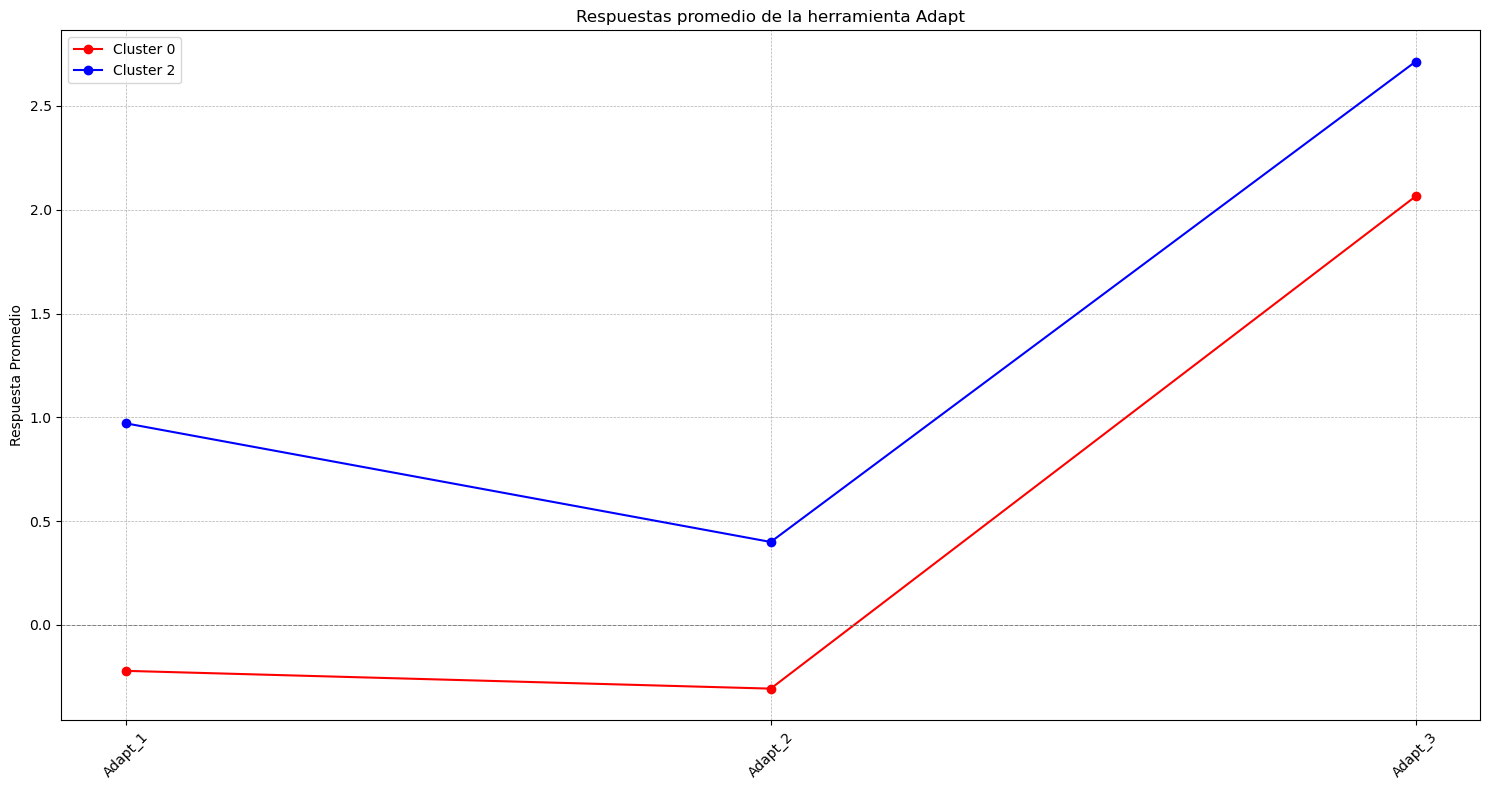

Adapt_1   Adapt_2   Adapt_3
label                              
0     -0.221539 -0.307183  2.064351
1      0.428703  0.047680  2.398115
2      0.970986  0.399450  2.713467

In [53]:
cluster_means = df_raw.groupby('label')[['Adapt_1', 'Adapt_2', 'Adapt_3',]].mean()

# Visualizar las respuestas promedio para cada clúster en un gráfico
plt.figure(figsize=(15, 8))
for cluster, color in zip([0,2], ['red', 'blue']):
    plt.plot(cluster_means.columns, cluster_means.loc[cluster], color=color, marker='o', label=f'Cluster {cluster}')

plt.title('Respuestas promedio de la herramienta Adapt')
plt.xticks(rotation=45)
plt.ylabel('Respuesta Promedio')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)  # línea de referencia para el valor "igual"
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

cluster_means

**Herramienta depress**

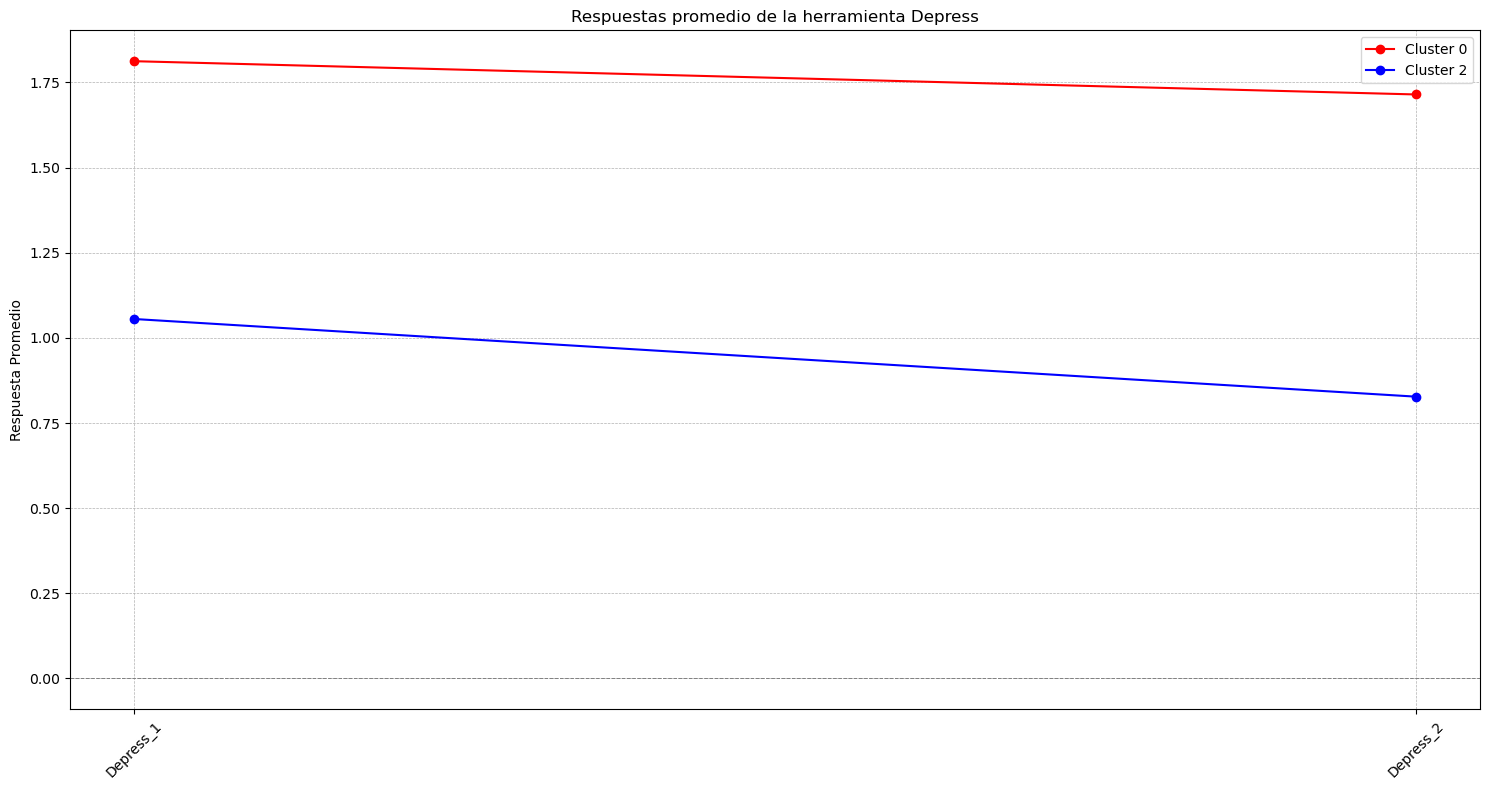

In [54]:
cluster_means = df_raw.groupby('label')[['Depress_1', 'Depress_2',]].mean()

# Visualizar las respuestas promedio para cada clúster en un gráfico
plt.figure(figsize=(15, 8))
for cluster, color in zip([0,2], ['red', 'blue']):
    plt.plot(cluster_means.columns, cluster_means.loc[cluster], color=color, marker='o', label=f'Cluster {cluster}')

plt.title('Respuestas promedio de la herramienta Depress')
plt.xticks(rotation=45)
plt.ylabel('Respuesta Promedio')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)  # línea de referencia para el valor "igual"
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


**Herramienta adherence_factor**

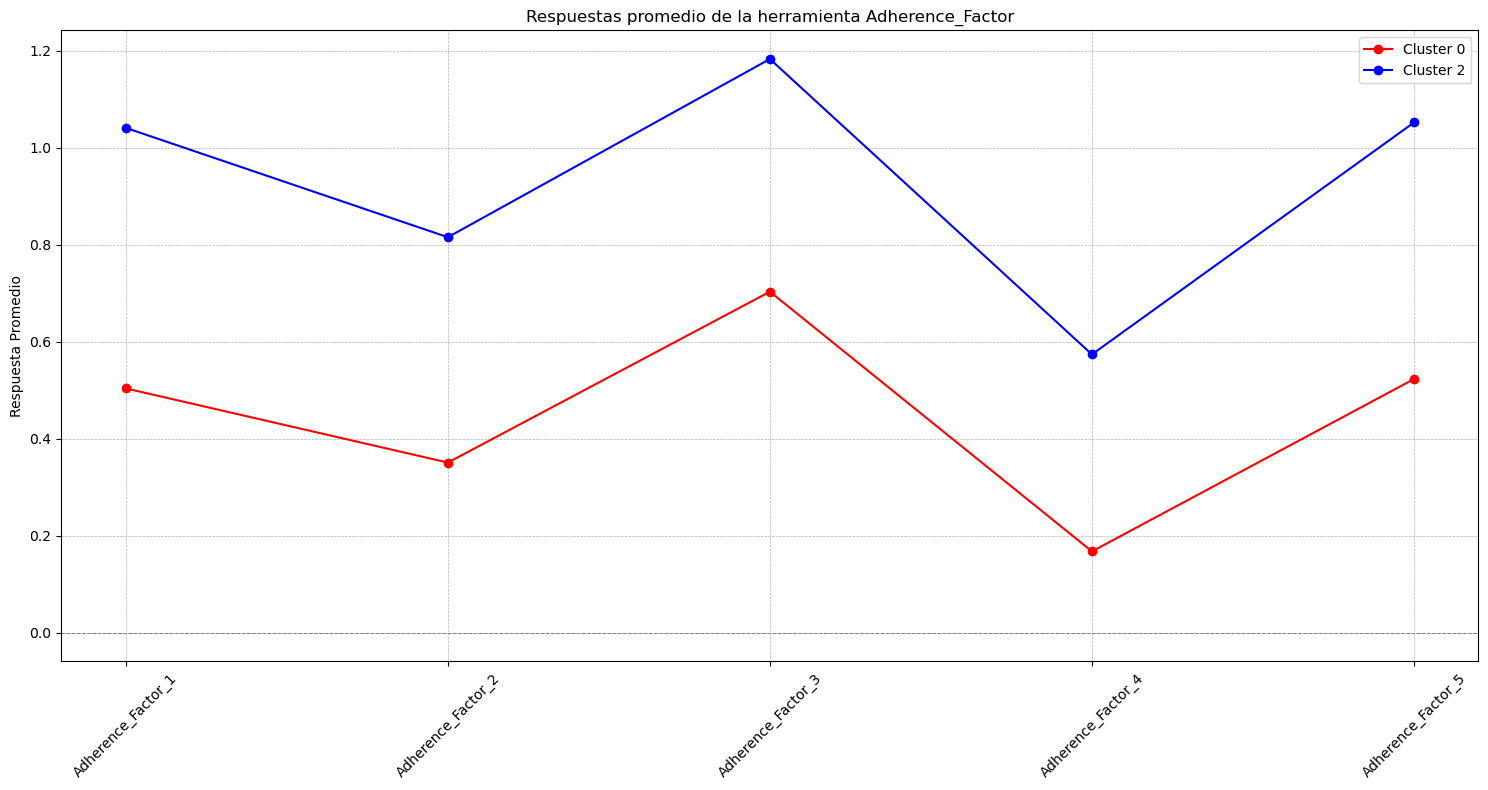

Adherence_Factor_1  Adherence_Factor_2  Adherence_Factor_3  \
label                                                               
0                0.503643            0.350714            0.703038   
1                0.785440            0.571683            0.972117   
2                1.040759            0.815339            1.182716   

       Adherence_Factor_4  Adherence_Factor_5  
label                                          
0                0.167597            0.522949  
1                0.350703            0.788502  
2                0.573714            1.051908

In [55]:
cluster_means = df_raw.groupby('label')[['Adherence_Factor_1', 'Adherence_Factor_2', 'Adherence_Factor_3', 'Adherence_Factor_4',
                                         'Adherence_Factor_5']].mean()

# Visualizar las respuestas promedio para cada clúster en un gráfico
plt.figure(figsize=(15, 8))
for cluster, color in zip([0,2], ['red', 'blue']):
    plt.plot(cluster_means.columns, cluster_means.loc[cluster], color=color, marker='o', label=f'Cluster {cluster}')

plt.title('Respuestas promedio de la herramienta Adherence_Factor')
plt.xticks(rotation=45)
plt.ylabel('Respuesta Promedio')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)  # línea de referencia para el valor "igual"
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

cluster_means

**Herramienta prevent_reason**

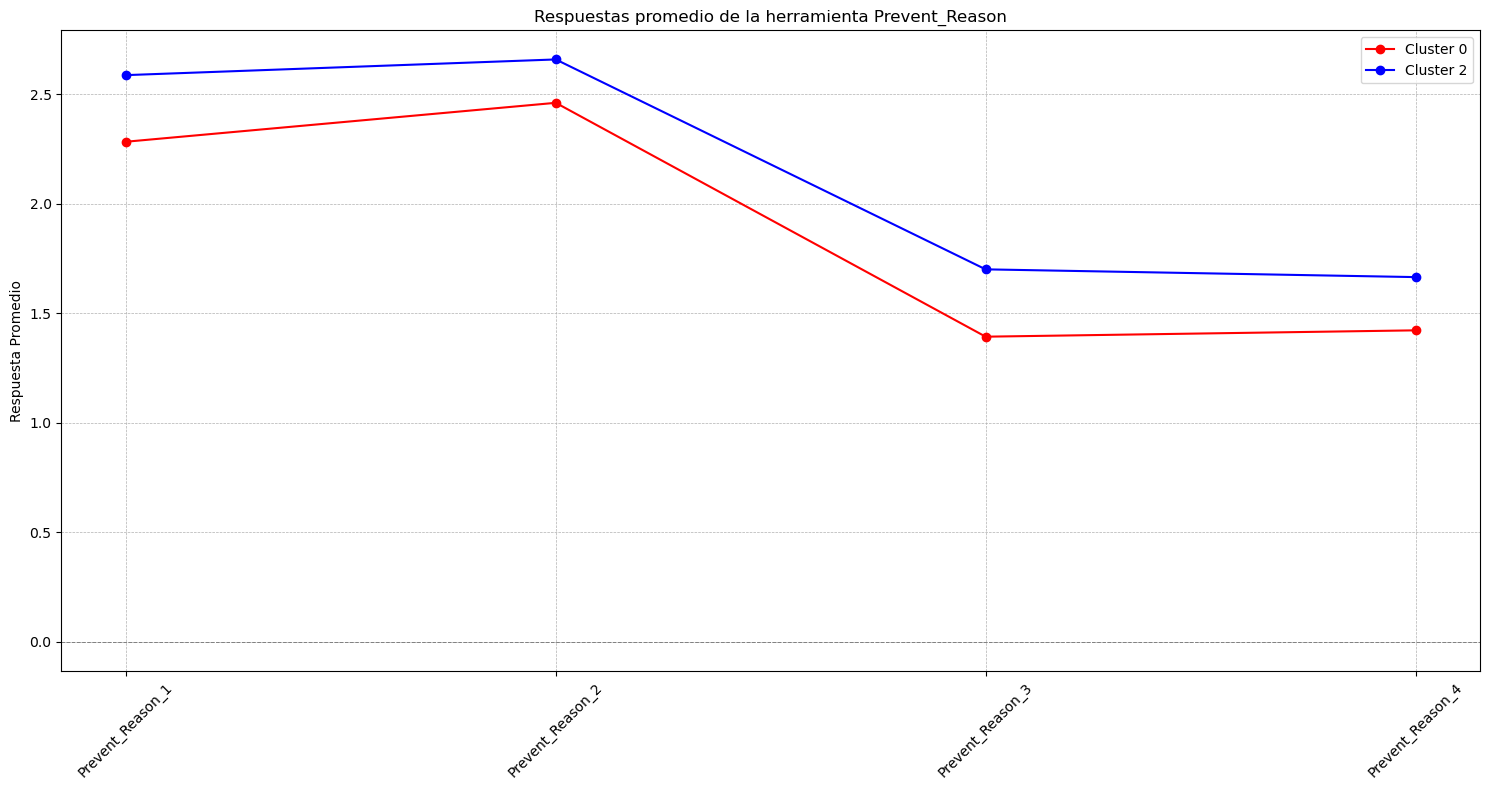

Prevent_Reason_1  Prevent_Reason_2  Prevent_Reason_3  Prevent_Reason_4
label                                                                        
0              2.282389          2.460112          1.392354          1.421312
1              2.434410          2.551024          1.465474          1.451235
2              2.586523          2.658136          1.699777          1.664385

In [56]:
cluster_means = df_raw.groupby('label')[['Prevent_Reason_1', 'Prevent_Reason_2', 'Prevent_Reason_3', 'Prevent_Reason_4']].mean()

# Visualizar las respuestas promedio para cada clúster en un gráfico
plt.figure(figsize=(15, 8))
for cluster, color in zip([0,2], ['red', 'blue']):
    plt.plot(cluster_means.columns, cluster_means.loc[cluster], color=color, marker='o', label=f'Cluster {cluster}')

plt.title('Respuestas promedio de la herramienta Prevent_Reason')
plt.xticks(rotation=45)
plt.ylabel('Respuesta Promedio')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)  # línea de referencia para el valor "igual"
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

cluster_means

# Estudio de densidad de la features por etiqueta mediante PMF

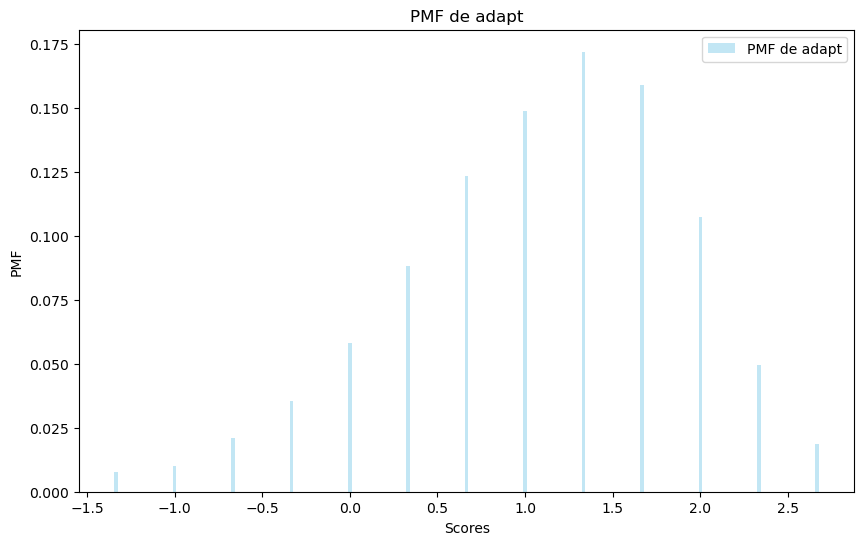

In [122]:
# Calcula las PMF de cada score
values_adapt, counts_adapt = np.unique(df['adapt'], return_counts=True)
pmf_adapt = counts_adapt / counts_adapt.sum()

# Graficar las PMF de los scores
plt.figure(figsize=(10, 6))
plt.bar(values_adapt, pmf_adapt, width=0.02, alpha=0.5, color='skyblue', label='PMF de adapt')

# Descripciones de la gráfica
plt.title('PMF de adapt')
plt.xlabel('Scores')
plt.ylabel('PMF')
plt.legend();

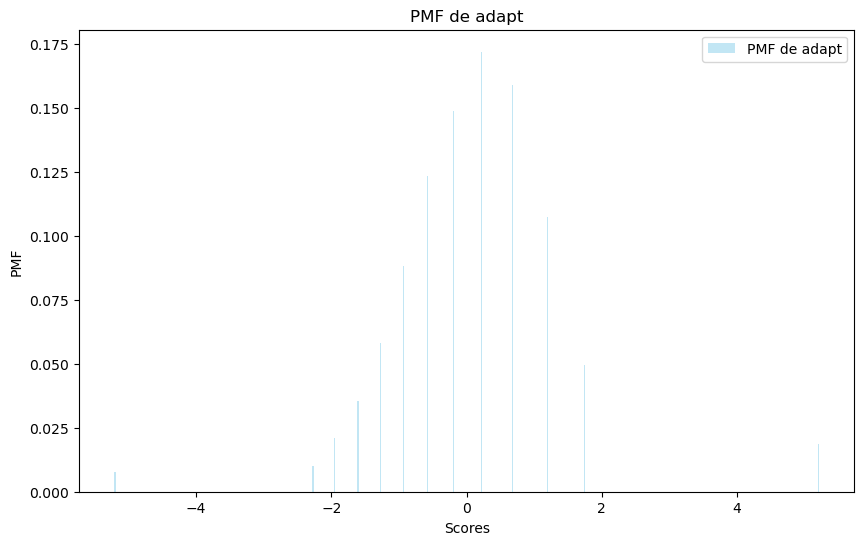

In [123]:
from sklearn.preprocessing import QuantileTransformer

data = df['adapt'].values.reshape(-1, 1)

# Aplicar la transformación de cuantiles para obtener una distribución gaussiana
quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=0)
data_gaussianized = quantile_transformer.fit_transform(data).flatten()

# Ahora data_gaussianized tiene una distribución que se aproxima a una normal
# Puedes calcular la PMF como antes si es necesario
values_gauss, counts_gauss = np.unique(data_gaussianized, return_counts=True)
pmf_gauss = counts_gauss / counts_gauss.sum()


plt.figure(figsize=(10, 6))
plt.bar(values_gauss, pmf_gauss, width=0.02, alpha=0.5, color='skyblue', label='PMF de adapt')

# Descripciones de la gráfica
plt.title('PMF de adapt')
plt.xlabel('Scores')
plt.ylabel('PMF')
plt.legend();

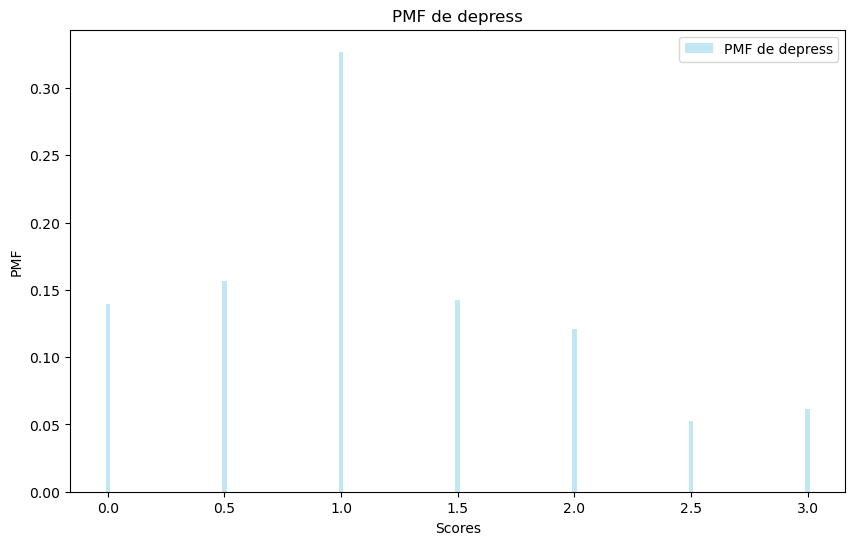

In [124]:
# Calcula las PMF de cada score
values_depress, counts_depress = np.unique(df['depress'], return_counts=True)
pmf_depress = counts_depress / counts_depress.sum()

# Graficar las PMF de los scores
plt.figure(figsize=(10, 6))
plt.bar(values_depress, pmf_depress, width=0.02, alpha=0.5, color='skyblue', label='PMF de depress')

# Descripciones de la gráfica
plt.title('PMF de depress')
plt.xlabel('Scores')
plt.ylabel('PMF')
plt.legend();

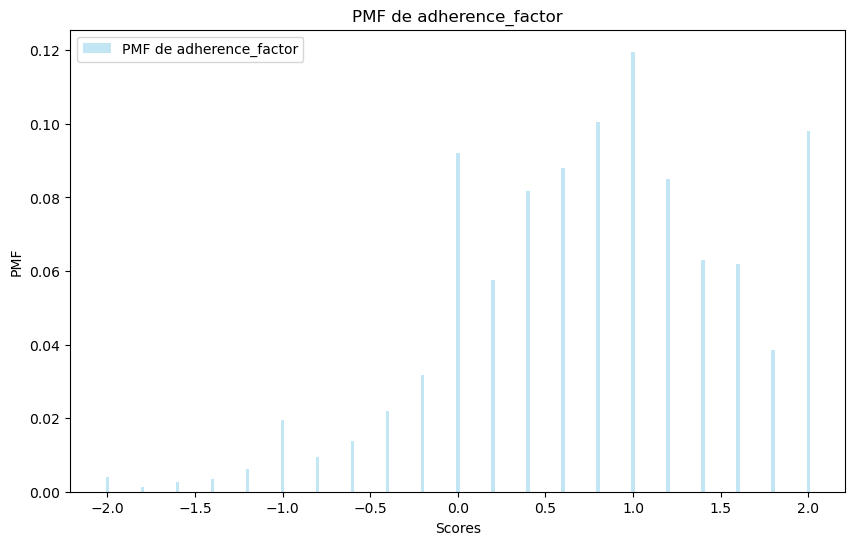

In [125]:
# Calcula las PMF de cada score
values_adherence_factor, counts_adherence_factor = np.unique(df['adherence_factor'], return_counts=True)
pmf_adherence_factor = counts_adherence_factor / counts_adherence_factor.sum()

# Graficar las PMF de los scores
plt.figure(figsize=(10, 6))
plt.bar(values_adherence_factor, pmf_adherence_factor, width=0.02, alpha=0.5, color='skyblue', label='PMF de adherence_factor')

# Descripciones de la gráfica
plt.title('PMF de adherence_factor')
plt.xlabel('Scores')
plt.ylabel('PMF')
plt.legend();

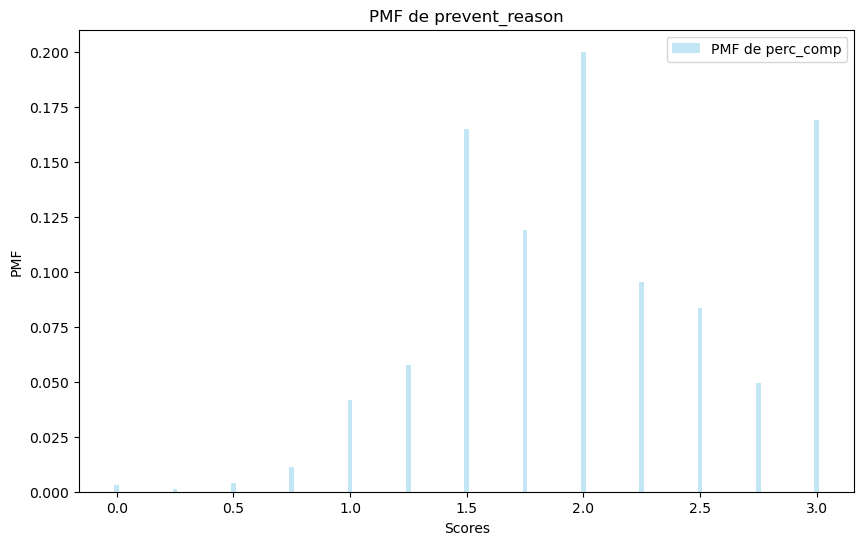

In [57]:
# Calcula las PMF de cada score
values_perc_comp, counts_perc_comp = np.unique(df['prevent_reason'], return_counts=True)
pmf_perc_comp = counts_perc_comp / counts_perc_comp.sum()

# Graficar las PMF de los scores
plt.figure(figsize=(10, 6))
plt.bar(values_perc_comp, pmf_perc_comp, width=0.02, alpha=0.5, color='skyblue', label='PMF de perc_comp')

# Descripciones de la gráfica
plt.title('PMF de prevent_reason')
plt.xlabel('Scores')
plt.ylabel('PMF')
plt.legend();

# Entrenamiento de modelos

In [127]:
train = train[['adapt','depress','adherence_factor','prevent_reason']]

In [128]:
sm_model = sm.Logit(y_train,sm.add_constant(train),)
result=sm_model.fit()
stats=result.summary()
print(stats)

Optimization terminated successfully.
         Current function value: 0.501534
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                18000
Model:                          Logit   Df Residuals:                    17995
Method:                           MLE   Df Model:                            4
Date:                Tue, 27 Feb 2024   Pseudo R-squ.:                  0.2764
Time:                        12:04:53   Log-Likelihood:                -9027.6
converged:                       True   LL-Null:                       -12477.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -3.9371      0.108    -36.450      0.000      -4.149      -3.725
adapt      

In [129]:
test = test[['adapt','depress','adherence_factor','prevent_reason']]

In [130]:
y_pred_probs = result.predict(exog=sm.add_constant(test))
y_pred = (y_pred_probs >= 0.5).astype(int)

Accuracy: 0.7475
Confusion Matrix:
[[723 300]
 [205 772]]
AUC Score: 0.8309920948181588
F1 Score: 0.7535383113714007


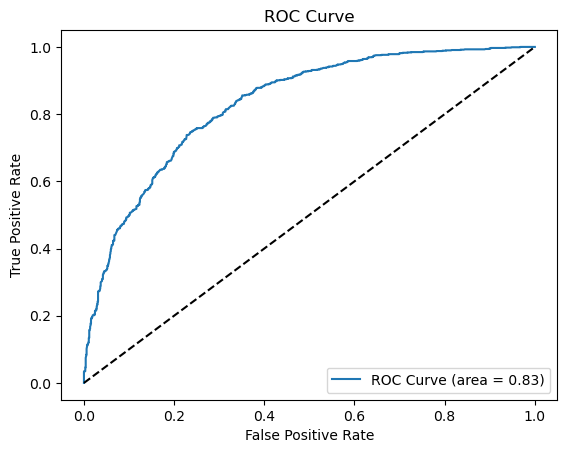

In [131]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

# Calcular la puntuación AUC
# Para AUC necesitamos las probabilidades, no las clases predichas
auc_score = roc_auc_score(y_test, y_pred_probs)
print(f"AUC Score: {auc_score}")

# Calcular la puntuación F1
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

# Generar la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [132]:
import tensorflow as tf
from tensorflow import keras

model = tf.keras.Sequential([
    keras.layers.Dense(950, input_shape=(4,), activation='swish'),
    keras.layers.Dropout(.5),
    keras.layers.Dense(950, activation='relu'),
    keras.layers.Dropout(.5),
    keras.layers.Dense(950, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.metrics.BinaryAccuracy()]
)
CB = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, mode='min', restore_best_weights=True)
model.fit(train, y_train_1, validation_data=(test, y_test_1), epochs=1000, callbacks=CB)
model.evaluate(test, y_test_1)

Epoch 1/1000
563/563 [==============================] - 2s 3ms/step - loss: 0.5264 - binary_accuracy: 0.7406 - val_loss: 0.5120 - val_binary_accuracy: 0.7475
Epoch 2/1000
563/563 [==============================] - 2s 3ms/step - loss: 0.5125 - binary_accuracy: 0.7507 - val_loss: 0.5047 - val_binary_accuracy: 0.7505
Epoch 3/1000
563/563 [==============================] - 2s 3ms/step - loss: 0.5112 - binary_accuracy: 0.7532 - val_loss: 0.5233 - val_binary_accuracy: 0.7410
Epoch 4/1000
563/563 [==============================] - 2s 3ms/step - loss: 0.5101 - binary_accuracy: 0.7527 - val_loss: 0.5172 - val_binary_accuracy: 0.7515
Epoch 5/1000
563/563 [==============================] - 2s 3ms/step - loss: 0.5103 - binary_accuracy: 0.7528 - val_loss: 0.5065 - val_binary_accuracy: 0.7515
Epoch 6/1000
563/563 [==============================] - 2s 3ms/step - loss: 0.5078 - binary_accuracy: 0.7523 - val_loss: 0.5214 - val_binary_accuracy: 0.7440
Epoch 7/1000
563/563 [==============================

[0.4992561638355255, 0.7620000243186951]

In [133]:
y_pred_probs = model.predict(test)
y_pred = (y_pred_probs >= 0.5).astype(int)

63/63 [==============================] - 0s 790us/step


Accuracy: 0.762
Confusion Matrix:
[[724 299]
 [177 800]]
AUC Score: 0.835674071583868
F1 Score: 0.7707129094412332


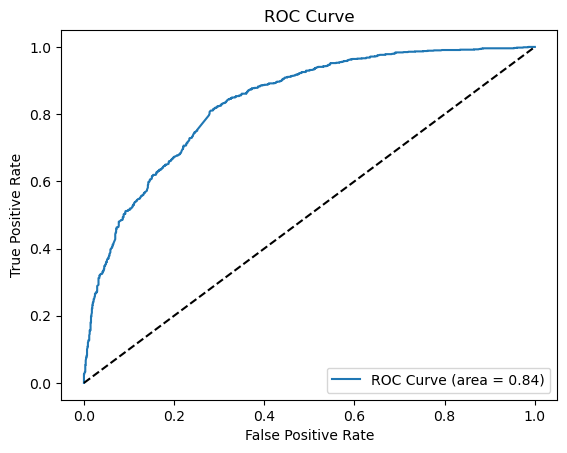

In [134]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

# Calcular la puntuación AUC
# Para AUC necesitamos las probabilidades, no las clases predichas
auc_score = roc_auc_score(y_test, y_pred_probs)
print(f"AUC Score: {auc_score}")

# Calcular la puntuación F1
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

# Generar la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Antes y despues de una feature selection \
             Antes    |     Despues\
Accuracy:    0.778    |      0.762   \
AUC Score:   0.860    |      0.835   \
F1 Score:    0.776    |      0.770

La comparación entre los resultados es clara, la diferencia entre el rendimiento de los modelos antes y despues de una feature selection es considerablemente menor, asi mismo es importante remarcar la limitada capacidad de los algoritmos de encontrar una relación entre las variables objetivo y las features. 

**Incluir critica objetiva al instrumento AQUI**